In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [4]:
import keras.utils
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
df = pd.read_csv('Data/16M_7_day_lag_with_price_changes.csv', 
                 usecols=['date', 'compound', 'negative', 'positive', 'daily_count', 'price_direction', 'price_change', 'lagged_close'])

In [6]:
df = df[df['date'] >= '2018-08-28']

In [7]:
df

,date,negative,positive,compound,daily_count,lagged_close,price_change,price_direction
278,2018-08-28,0.007695,0.028635,0.062261,750,7361.660156,265.380371,positive
279,2018-08-29,0.006276,0.028844,0.072007,736,6792.830078,254.330078,negative
280,2018-08-30,0.009227,0.029736,0.064531,746,6529.169922,449.060059,negative
281,2018-08-31,0.008908,0.027812,0.055598,682,6467.069824,570.510254,negative
282,2018-09-01,0.008893,0.025307,0.049348,642,6225.979980,967.270020,negative
...,...,...,...,...,...,...,...,...
726,2019-11-19,0.038151,0.093721,0.165424,43287,7218.371094,987.774414,negative
727,2019-11-20,0.036158,0.099087,0.181522,42112,7531.663574,495.604492,negative
728,2019-11-21,0.042986,0.096216,0.155917,47978,7463.105957,179.644043,negative
729,2019-11-22,0.048450,0.090741,0.129012,51043,7761.243652,464.666016,positive


In [8]:
# Label encoding
le = LabelEncoder()

df['price_direction'] = le.fit_transform(df['price_direction'])

In [9]:
# Copying df for further manipulations
df_copy = df.copy()

In [10]:
features = ['price_direction', 'lagged_close', 'positive', 'negative', 'daily_count']

In [11]:
df_copy = df_copy[features]

In [12]:
# Number of previous records to consider for every example (Window size)
n_lag = 3

# Number of features
n_features = len(features)

# Calculate total_features
total_features = n_lag * n_features

if(total_features == 0):
    total_features = n_features

In [13]:
def create_lagged_features(data, n_lagged_features=1, to_remove=1):
    variables = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    columns, names = list(), list()
    
    for i in range(n_lagged_features, 0, -1):
        columns.append(df.shift(i))
        names += [f'feature{j+1}(t-{i})' for j in range(variables)]

    for i in range(0, to_remove):
        columns.append(df.shift(-i))
        if i == 0:
            names += [f'feature{j+1}(t)' for j in range(variables)]
        else:
            names += [f'feature{j+1}(t+{i})' for j in range(variables)]
            
    prepped_df = pd.concat(columns, axis=1)
    prepped_df.columns = names
    
    # Drop rows with NaN values
    prepped_df.dropna(inplace=True)
        
    return prepped_df

In [14]:
# Create lagged data (previous data window) columns
lagged_data = create_lagged_features(df_copy, n_lag, 1)
lagged_data = lagged_data.reset_index()
lagged_data = lagged_data.drop(['index'], axis=1)

In [15]:
lagged_data

,feature1(t-3),feature2(t-3),feature3(t-3),feature4(t-3),feature5(t-3),feature1(t-2),feature2(t-2),feature3(t-2),feature4(t-2),feature5(t-2),feature1(t-1),feature2(t-1),feature3(t-1),feature4(t-1),feature5(t-1),feature1(t),feature2(t),feature3(t),feature4(t),feature5(t)
0,1.0,7361.660156,0.028635,0.007695,750.0,0.0,6792.830078,0.028844,0.006276,736.0,0.0,6529.169922,0.029736,0.009227,746.0,0,6467.069824,0.027812,0.008908,682
1,0.0,6792.830078,0.028844,0.006276,736.0,0.0,6529.169922,0.029736,0.009227,746.0,0.0,6467.069824,0.027812,0.008908,682.0,0,6225.979980,0.025307,0.008893,642
2,0.0,6529.169922,0.029736,0.009227,746.0,0.0,6467.069824,0.027812,0.008908,682.0,0.0,6225.979980,0.025307,0.008893,642.0,0,6300.859863,0.028598,0.010656,659
3,0.0,6467.069824,0.027812,0.008908,682.0,0.0,6225.979980,0.025307,0.008893,642.0,0.0,6300.859863,0.028598,0.010656,659.0,0,6329.700195,0.024956,0.009593,707
4,0.0,6225.979980,0.025307,0.008893,642.0,0.0,6300.859863,0.028598,0.010656,659.0,0.0,6329.700195,0.024956,0.009593,707.0,0,6321.200195,0.025445,0.006964,719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0.0,7397.796875,0.093754,0.039901,33199.0,0.0,7047.916992,0.092225,0.039410,33029.0,0.0,7146.133789,0.090824,0.037751,41172.0,0,7218.371094,0.093721,0.038151,43287
446,0.0,7047.916992,0.092225,0.039410,33029.0,0.0,7146.133789,0.090824,0.037751,41172.0,0.0,7218.371094,0.093721,0.038151,43287.0,0,7531.663574,0.099087,0.036158,42112
447,0.0,7146.133789,0.090824,0.037751,41172.0,0.0,7218.371094,0.093721,0.038151,43287.0,0.0,7531.663574,0.099087,0.036158,42112.0,0,7463.105957,0.096216,0.042986,47978
448,0.0,7218.371094,0.093721,0.038151,43287.0,0.0,7531.663574,0.099087,0.036158,42112.0,0.0,7463.105957,0.096216,0.042986,47978.0,1,7761.243652,0.090741,0.048450,51043


In [15]:
X = lagged_data.iloc[:, :total_features].values
y = lagged_data['feature1(t)'].values

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=4)

In [17]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (382, 15) (382,)
Testing set shape: (68, 15) (68,)


In [18]:
# Normalise features
xscaler = MinMaxScaler(feature_range=(0, 1))
X_train = xscaler.fit_transform(X_train)
X_test = xscaler.transform(X_test)

In [19]:
# Reshape to match LSTM input [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_lag, n_features))
X_test = X_test.reshape((X_test.shape[0], n_lag, n_features))

In [20]:
X_train.shape

(382, 3, 5)

In [21]:
# Set two class values (1-hot method)
y_train = keras.utils.to_categorical(y_train, 2)

### LSTM Model

In [22]:
EPOCHS = 10000

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [24]:
y_eval = keras.utils.to_categorical(y_test, 2)

In [25]:
# Optimize hyperparameters
import optuna

In [26]:
np.random.seed(1) 
tf.random.set_seed(1)

In [27]:
def objective(trial):
    activation_funcs = ['relu', 'tanh', 'selu', 'swish']

    # Hyperparameters that will be changed
    activation_func_1 = trial.suggest_categorical('activation_func_1', activation_funcs)
    activation_func_2 = trial.suggest_categorical('activation_func_2', activation_funcs)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 80])
    dropout_1 = trial.suggest_categorical('dropout_1', [0.25, 0.5])
    dropout_2 = trial.suggest_categorical('dropout_2', [0.25, 0.5])
    neurons = trial.suggest_int('neurons', 64, 128, log=True)
    
    model = Sequential()
    model.add(Bidirectional(LSTM(
        neurons, 
        return_sequences=True, 
        input_shape=(X_train.shape[1], X_train.shape[2]),
        activation=activation_func_1)))
    model.add(Dropout(dropout_1))
    model.add(Bidirectional(LSTM(
        neurons, 
        return_sequences=False, 
        activation=activation_func_2)))
    model.add(Dropout(dropout_2))
    model.add(Dense(2, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
      
    model.fit(X_train, 
              y_train, 
              epochs=EPOCHS,
              batch_size=batch_size, 
              verbose=2, 
              shuffle=True,
              validation_split=0.2, 
              callbacks=[early_stopping])
    
    # Evaluate the model on the validation data
    validation_accuracy = model.evaluate(X_test, y_eval)[1]

    return validation_accuracy

In [28]:
import time

In [29]:
study = optuna.create_study(storage='sqlite:///db.sqlite3', 
                            study_name='BiLSTM_direction_change_7_day_lag_3_day_window',
                            direction='maximize')

start_time = time.time()

study.optimize(objective, n_trials=100)

elapsed_time = time.time() - start_time
print(f'Elapsed Time: {elapsed_time:.2f} seconds')

[I 2023-07-24 18:22:45,550] A new study created in RDB with name: BiLSTM_direction_change_7_day_lag_3_day_window


Epoch 1/10000
5/5 - 7s - loss: 0.6694 - accuracy: 0.6197 - val_loss: 0.6330 - val_accuracy: 0.6883 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.5954 - accuracy: 0.7672 - val_loss: 0.5941 - val_accuracy: 0.7013 - 97ms/epoch - 19ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.5629 - accuracy: 0.7574 - val_loss: 0.5929 - val_accuracy: 0.6883 - 101ms/epoch - 20ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.5427 - accuracy: 0.7541 - val_loss: 0.5853 - val_accuracy: 0.7143 - 107ms/epoch - 21ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5330 - accuracy: 0.7836 - val_loss: 0.5615 - val_accuracy: 0.7273 - 99ms/epoch - 20ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5203 - accuracy: 0.7869 - val_loss: 0.5416 - val_accuracy: 0.7403 - 104ms/epoch - 21ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5116 - accuracy: 0.7869 - val_loss: 0.5362 - val_accuracy: 0.7273 - 98ms/epoch - 20ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.4945 - accuracy: 0.7836 - val_loss: 0.5194 - val_accuracy: 0.7922 - 107ms/epoch - 21ms/step
Epoch 9/

[I 2023-07-24 18:22:55,409] Trial 0 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 122}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6909 - accuracy: 0.5475 - val_loss: 0.6823 - val_accuracy: 0.6883 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6743 - accuracy: 0.7279 - val_loss: 0.6659 - val_accuracy: 0.7013 - 65ms/epoch - 16ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6552 - accuracy: 0.7574 - val_loss: 0.6468 - val_accuracy: 0.7013 - 64ms/epoch - 16ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6323 - accuracy: 0.7508 - val_loss: 0.6234 - val_accuracy: 0.7143 - 67ms/epoch - 17ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6042 - accuracy: 0.7508 - val_loss: 0.5987 - val_accuracy: 0.7273 - 73ms/epoch - 18ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5758 - accuracy: 0.7607 - val_loss: 0.5796 - val_accuracy: 0.7013 - 72ms/epoch - 18ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5588 - accuracy: 0.7410 - val_loss: 0.5777 - val_accuracy: 0.6753 - 77ms/epoch - 19ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5432 - accuracy: 0.7508 - val_loss: 0.5645 - val_accuracy: 0.7273 - 70ms/epoch - 18ms/step
Epoch 9/1000

[I 2023-07-24 18:23:03,685] Trial 1 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 75}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 7s - loss: 0.6901 - accuracy: 0.6033 - val_loss: 0.6866 - val_accuracy: 0.7013 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6826 - accuracy: 0.7443 - val_loss: 0.6789 - val_accuracy: 0.7273 - 62ms/epoch - 12ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6738 - accuracy: 0.7639 - val_loss: 0.6703 - val_accuracy: 0.7013 - 65ms/epoch - 13ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6624 - accuracy: 0.7639 - val_loss: 0.6590 - val_accuracy: 0.7013 - 68ms/epoch - 14ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.6486 - accuracy: 0.7639 - val_loss: 0.6435 - val_accuracy: 0.7013 - 72ms/epoch - 14ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.6314 - accuracy: 0.7607 - val_loss: 0.6240 - val_accuracy: 0.7143 - 65ms/epoch - 13ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.6108 - accuracy: 0.7475 - val_loss: 0.6050 - val_accuracy: 0.6883 - 64ms/epoch - 13ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5764 - accuracy: 0.7508 - val_loss: 0.5838 - val_accuracy: 0.6883 - 69ms/epoch - 14ms/step
Epoch 9/1000

[I 2023-07-24 18:23:14,539] Trial 2 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 5s - loss: 0.6872 - accuracy: 0.6131 - val_loss: 0.6792 - val_accuracy: 0.6753 - 5s/epoch - 519ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.6664 - accuracy: 0.7639 - val_loss: 0.6517 - val_accuracy: 0.6883 - 108ms/epoch - 11ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.6343 - accuracy: 0.7410 - val_loss: 0.6076 - val_accuracy: 0.6753 - 123ms/epoch - 12ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5746 - accuracy: 0.7475 - val_loss: 0.5639 - val_accuracy: 0.7013 - 110ms/epoch - 11ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5393 - accuracy: 0.7803 - val_loss: 0.5432 - val_accuracy: 0.7273 - 118ms/epoch - 12ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5284 - accuracy: 0.7770 - val_loss: 0.5252 - val_accuracy: 0.7403 - 123ms/epoch - 12ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5192 - accuracy: 0.7803 - val_loss: 0.5131 - val_accuracy: 0.7403 - 107ms/epoch - 11ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.5117 - accuracy: 0.7869 - val_loss: 0.5031 - val_accuracy: 0.7662 - 118ms/epoc

[I 2023-07-24 18:23:23,139] Trial 3 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 82}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6767 - accuracy: 0.6426 - val_loss: 0.6571 - val_accuracy: 0.6753 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6381 - accuracy: 0.7574 - val_loss: 0.6197 - val_accuracy: 0.7013 - 88ms/epoch - 22ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.5910 - accuracy: 0.7607 - val_loss: 0.5884 - val_accuracy: 0.6883 - 90ms/epoch - 23ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5605 - accuracy: 0.7443 - val_loss: 0.5711 - val_accuracy: 0.6883 - 92ms/epoch - 23ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5518 - accuracy: 0.7574 - val_loss: 0.5618 - val_accuracy: 0.7273 - 87ms/epoch - 22ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5261 - accuracy: 0.7934 - val_loss: 0.5549 - val_accuracy: 0.7273 - 92ms/epoch - 23ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5275 - accuracy: 0.7803 - val_loss: 0.5511 - val_accuracy: 0.7143 - 94ms/epoch - 23ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5163 - accuracy: 0.7607 - val_loss: 0.5262 - val_accuracy: 0.7403 - 87ms/epoch - 22ms/step
Epoch 9/1000

[I 2023-07-24 18:23:31,072] Trial 4 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 99}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 7s - loss: 0.6427 - accuracy: 0.6918 - val_loss: 0.6083 - val_accuracy: 0.6883 - 7s/epoch - 687ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.5660 - accuracy: 0.7639 - val_loss: 0.5857 - val_accuracy: 0.7013 - 149ms/epoch - 15ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5677 - accuracy: 0.7410 - val_loss: 0.5697 - val_accuracy: 0.7273 - 148ms/epoch - 15ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5356 - accuracy: 0.7705 - val_loss: 0.5515 - val_accuracy: 0.7273 - 150ms/epoch - 15ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5181 - accuracy: 0.7705 - val_loss: 0.5340 - val_accuracy: 0.7403 - 159ms/epoch - 16ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5082 - accuracy: 0.7869 - val_loss: 0.5246 - val_accuracy: 0.7403 - 156ms/epoch - 16ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5045 - accuracy: 0.7902 - val_loss: 0.5211 - val_accuracy: 0.7662 - 154ms/epoch - 15ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.4939 - accuracy: 0.8033 - val_loss: 0.5087 - val_accuracy: 0.8052 - 157ms/epoc

[I 2023-07-24 18:23:41,807] Trial 5 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 94}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 7s - loss: 0.6556 - accuracy: 0.7016 - val_loss: 0.6386 - val_accuracy: 0.7013 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6033 - accuracy: 0.7574 - val_loss: 0.6043 - val_accuracy: 0.7013 - 90ms/epoch - 18ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.5808 - accuracy: 0.7508 - val_loss: 0.5892 - val_accuracy: 0.7013 - 90ms/epoch - 18ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.5547 - accuracy: 0.7607 - val_loss: 0.5844 - val_accuracy: 0.7013 - 90ms/epoch - 18ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5327 - accuracy: 0.7672 - val_loss: 0.5761 - val_accuracy: 0.7273 - 86ms/epoch - 17ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5259 - accuracy: 0.7836 - val_loss: 0.5627 - val_accuracy: 0.7273 - 91ms/epoch - 18ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5232 - accuracy: 0.7705 - val_loss: 0.5559 - val_accuracy: 0.7143 - 85ms/epoch - 17ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5090 - accuracy: 0.7836 - val_loss: 0.5335 - val_accuracy: 0.7403 - 87ms/epoch - 17ms/step
Epoch 9/1000

[I 2023-07-24 18:23:51,710] Trial 6 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 71}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6886 - accuracy: 0.6197 - val_loss: 0.6773 - val_accuracy: 0.7013 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6679 - accuracy: 0.7213 - val_loss: 0.6544 - val_accuracy: 0.7532 - 216ms/epoch - 54ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6408 - accuracy: 0.7443 - val_loss: 0.6269 - val_accuracy: 0.7143 - 301ms/epoch - 75ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6076 - accuracy: 0.7541 - val_loss: 0.5952 - val_accuracy: 0.7013 - 305ms/epoch - 76ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5646 - accuracy: 0.7574 - val_loss: 0.5717 - val_accuracy: 0.7143 - 313ms/epoch - 78ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5408 - accuracy: 0.7672 - val_loss: 0.5703 - val_accuracy: 0.7013 - 317ms/epoch - 79ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5378 - accuracy: 0.7541 - val_loss: 0.5797 - val_accuracy: 0.6883 - 309ms/epoch - 77ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5314 - accuracy: 0.7738 - val_loss: 0.5523 - val_accuracy: 0.7403 - 319ms/epoch - 80ms/step
Epoch

[I 2023-07-24 18:24:06,333] Trial 7 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 114}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 7s - loss: 0.6847 - accuracy: 0.6361 - val_loss: 0.6773 - val_accuracy: 0.7013 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6682 - accuracy: 0.7508 - val_loss: 0.6614 - val_accuracy: 0.7013 - 161ms/epoch - 40ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6501 - accuracy: 0.7508 - val_loss: 0.6432 - val_accuracy: 0.6753 - 155ms/epoch - 39ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6289 - accuracy: 0.7377 - val_loss: 0.6212 - val_accuracy: 0.7013 - 159ms/epoch - 40ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6014 - accuracy: 0.7574 - val_loss: 0.5976 - val_accuracy: 0.7013 - 163ms/epoch - 41ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5696 - accuracy: 0.7607 - val_loss: 0.5773 - val_accuracy: 0.7013 - 160ms/epoch - 40ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5523 - accuracy: 0.7410 - val_loss: 0.5691 - val_accuracy: 0.6753 - 164ms/epoch - 41ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5365 - accuracy: 0.7541 - val_loss: 0.5606 - val_accuracy: 0.7143 - 163ms/epoch - 41ms/step
Epoch

[I 2023-07-24 18:24:20,176] Trial 8 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 72}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6832 - accuracy: 0.5705 - val_loss: 0.6643 - val_accuracy: 0.6753 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6517 - accuracy: 0.7344 - val_loss: 0.6326 - val_accuracy: 0.7013 - 201ms/epoch - 50ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6083 - accuracy: 0.7508 - val_loss: 0.5996 - val_accuracy: 0.6753 - 234ms/epoch - 59ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5673 - accuracy: 0.7508 - val_loss: 0.5734 - val_accuracy: 0.7143 - 223ms/epoch - 56ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5415 - accuracy: 0.7639 - val_loss: 0.5638 - val_accuracy: 0.7273 - 227ms/epoch - 57ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5322 - accuracy: 0.7738 - val_loss: 0.5617 - val_accuracy: 0.7273 - 236ms/epoch - 59ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5239 - accuracy: 0.7738 - val_loss: 0.5590 - val_accuracy: 0.7013 - 220ms/epoch - 55ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5152 - accuracy: 0.7803 - val_loss: 0.5303 - val_accuracy: 0.7403 - 224ms/epoch - 56ms/step
Epoch

[I 2023-07-24 18:24:30,343] Trial 9 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 94}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 6s - loss: 0.6835 - accuracy: 0.6754 - val_loss: 0.6740 - val_accuracy: 0.6753 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6602 - accuracy: 0.7410 - val_loss: 0.6500 - val_accuracy: 0.6883 - 277ms/epoch - 55ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6284 - accuracy: 0.7475 - val_loss: 0.6166 - val_accuracy: 0.6883 - 316ms/epoch - 63ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.5843 - accuracy: 0.7541 - val_loss: 0.5843 - val_accuracy: 0.7013 - 298ms/epoch - 60ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5461 - accuracy: 0.7607 - val_loss: 0.5730 - val_accuracy: 0.7013 - 311ms/epoch - 62ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5498 - accuracy: 0.7738 - val_loss: 0.5632 - val_accuracy: 0.7273 - 295ms/epoch - 59ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5357 - accuracy: 0.7770 - val_loss: 0.5495 - val_accuracy: 0.7273 - 288ms/epoch - 58ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5192 - accuracy: 0.7803 - val_loss: 0.5303 - val_accuracy: 0.7403 - 294ms/epoch - 59ms/step
Epoch

[I 2023-07-24 18:24:42,562] Trial 10 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 126}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 7s - loss: 0.6889 - accuracy: 0.5836 - val_loss: 0.6834 - val_accuracy: 0.6753 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6769 - accuracy: 0.7508 - val_loss: 0.6701 - val_accuracy: 0.7143 - 225ms/epoch - 45ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6614 - accuracy: 0.7541 - val_loss: 0.6525 - val_accuracy: 0.7143 - 243ms/epoch - 49ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6377 - accuracy: 0.7475 - val_loss: 0.6284 - val_accuracy: 0.6883 - 245ms/epoch - 49ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.6043 - accuracy: 0.7705 - val_loss: 0.5994 - val_accuracy: 0.6883 - 240ms/epoch - 48ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5686 - accuracy: 0.7672 - val_loss: 0.5785 - val_accuracy: 0.7013 - 255ms/epoch - 51ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5563 - accuracy: 0.7410 - val_loss: 0.5869 - val_accuracy: 0.6753 - 261ms/epoch - 52ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5456 - accuracy: 0.7508 - val_loss: 0.5692 - val_accuracy: 0.7273 - 260ms/epoch - 52ms/step
Epoch

[I 2023-07-24 18:25:00,792] Trial 11 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 111}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 6s - loss: 0.6878 - accuracy: 0.6033 - val_loss: 0.6807 - val_accuracy: 0.6753 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6708 - accuracy: 0.7344 - val_loss: 0.6663 - val_accuracy: 0.6753 - 177ms/epoch - 44ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6528 - accuracy: 0.7311 - val_loss: 0.6490 - val_accuracy: 0.6753 - 197ms/epoch - 49ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6255 - accuracy: 0.7410 - val_loss: 0.6269 - val_accuracy: 0.6753 - 203ms/epoch - 51ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6018 - accuracy: 0.7410 - val_loss: 0.6026 - val_accuracy: 0.6883 - 203ms/epoch - 51ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5697 - accuracy: 0.7639 - val_loss: 0.5863 - val_accuracy: 0.7013 - 211ms/epoch - 53ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5556 - accuracy: 0.7443 - val_loss: 0.5877 - val_accuracy: 0.6883 - 202ms/epoch - 50ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5547 - accuracy: 0.7607 - val_loss: 0.5726 - val_accuracy: 0.7143 - 206ms/epoch - 51ms/step
Epoch

[I 2023-07-24 18:25:12,462] Trial 12 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 84}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 7s - loss: 0.6623 - accuracy: 0.6262 - val_loss: 0.6244 - val_accuracy: 0.6883 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.5866 - accuracy: 0.7508 - val_loss: 0.5904 - val_accuracy: 0.7013 - 241ms/epoch - 48ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.5462 - accuracy: 0.7475 - val_loss: 0.5874 - val_accuracy: 0.6883 - 270ms/epoch - 54ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.5462 - accuracy: 0.7574 - val_loss: 0.5798 - val_accuracy: 0.7273 - 275ms/epoch - 55ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5314 - accuracy: 0.7836 - val_loss: 0.5592 - val_accuracy: 0.7273 - 273ms/epoch - 55ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5141 - accuracy: 0.7803 - val_loss: 0.5429 - val_accuracy: 0.7403 - 277ms/epoch - 55ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5166 - accuracy: 0.7672 - val_loss: 0.5347 - val_accuracy: 0.7532 - 271ms/epoch - 54ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.4978 - accuracy: 0.7967 - val_loss: 0.5208 - val_accuracy: 0.7922 - 273ms/epoch - 55ms/step
Epoch

[I 2023-07-24 18:25:25,019] Trial 13 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 107}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 6s - loss: 0.6711 - accuracy: 0.6525 - val_loss: 0.6467 - val_accuracy: 0.6753 - 6s/epoch - 594ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.6051 - accuracy: 0.7639 - val_loss: 0.5871 - val_accuracy: 0.7013 - 302ms/epoch - 30ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5617 - accuracy: 0.7443 - val_loss: 0.5708 - val_accuracy: 0.7273 - 320ms/epoch - 32ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5485 - accuracy: 0.7672 - val_loss: 0.5586 - val_accuracy: 0.7273 - 325ms/epoch - 32ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5148 - accuracy: 0.7803 - val_loss: 0.5268 - val_accuracy: 0.7403 - 333ms/epoch - 33ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5074 - accuracy: 0.7934 - val_loss: 0.5152 - val_accuracy: 0.7662 - 353ms/epoch - 35ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5122 - accuracy: 0.7869 - val_loss: 0.5069 - val_accuracy: 0.8052 - 343ms/epoch - 34ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.4891 - accuracy: 0.8098 - val_loss: 0.5006 - val_accuracy: 0.8052 - 343ms/epoc

[I 2023-07-24 18:25:38,292] Trial 14 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 121}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 7s - loss: 0.6632 - accuracy: 0.6656 - val_loss: 0.6301 - val_accuracy: 0.7013 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.5948 - accuracy: 0.7541 - val_loss: 0.5972 - val_accuracy: 0.6883 - 235ms/epoch - 59ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.5551 - accuracy: 0.7574 - val_loss: 0.6038 - val_accuracy: 0.6753 - 246ms/epoch - 61ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5478 - accuracy: 0.7475 - val_loss: 0.5924 - val_accuracy: 0.7273 - 248ms/epoch - 62ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5353 - accuracy: 0.7770 - val_loss: 0.5636 - val_accuracy: 0.7273 - 259ms/epoch - 65ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5187 - accuracy: 0.7869 - val_loss: 0.5434 - val_accuracy: 0.7403 - 260ms/epoch - 65ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5166 - accuracy: 0.7738 - val_loss: 0.5313 - val_accuracy: 0.7273 - 247ms/epoch - 62ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.4988 - accuracy: 0.7902 - val_loss: 0.5149 - val_accuracy: 0.7922 - 259ms/epoch - 65ms/step
Epoch

[I 2023-07-24 18:25:50,583] Trial 15 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 126}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 6s - loss: 0.6924 - accuracy: 0.5738 - val_loss: 0.6912 - val_accuracy: 0.6753 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6900 - accuracy: 0.7475 - val_loss: 0.6885 - val_accuracy: 0.7532 - 222ms/epoch - 44ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6870 - accuracy: 0.7213 - val_loss: 0.6852 - val_accuracy: 0.7532 - 239ms/epoch - 48ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6831 - accuracy: 0.7443 - val_loss: 0.6808 - val_accuracy: 0.7532 - 236ms/epoch - 47ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.6771 - accuracy: 0.7508 - val_loss: 0.6743 - val_accuracy: 0.7532 - 239ms/epoch - 48ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.6700 - accuracy: 0.7508 - val_loss: 0.6652 - val_accuracy: 0.7403 - 241ms/epoch - 48ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.6588 - accuracy: 0.7475 - val_loss: 0.6537 - val_accuracy: 0.7013 - 245ms/epoch - 49ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.6422 - accuracy: 0.7541 - val_loss: 0.6376 - val_accuracy: 0.6883 - 241ms/epoch - 48ms/step
Epoch

[I 2023-07-24 18:26:12,047] Trial 16 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 104}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 5s - loss: 0.6753 - accuracy: 0.6230 - val_loss: 0.6594 - val_accuracy: 0.6753 - 5s/epoch - 987ms/step
Epoch 2/10000
5/5 - 0s - loss: 0.6395 - accuracy: 0.7377 - val_loss: 0.6257 - val_accuracy: 0.6883 - 155ms/epoch - 31ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6025 - accuracy: 0.7344 - val_loss: 0.5972 - val_accuracy: 0.6883 - 169ms/epoch - 34ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.5641 - accuracy: 0.7443 - val_loss: 0.5830 - val_accuracy: 0.6883 - 168ms/epoch - 34ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5424 - accuracy: 0.7705 - val_loss: 0.5775 - val_accuracy: 0.7013 - 177ms/epoch - 35ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5446 - accuracy: 0.7574 - val_loss: 0.5646 - val_accuracy: 0.7273 - 170ms/epoch - 34ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5291 - accuracy: 0.7738 - val_loss: 0.5560 - val_accuracy: 0.7273 - 174ms/epoch - 35ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5247 - accuracy: 0.7803 - val_loss: 0.5338 - val_accuracy: 0.7273 - 172ms/epoch - 34ms/step
Ep

[I 2023-07-24 18:26:21,099] Trial 17 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'relu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 85}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 7s - loss: 0.6892 - accuracy: 0.6000 - val_loss: 0.6848 - val_accuracy: 0.6753 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6799 - accuracy: 0.7475 - val_loss: 0.6740 - val_accuracy: 0.7532 - 237ms/epoch - 59ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6674 - accuracy: 0.7574 - val_loss: 0.6612 - val_accuracy: 0.7403 - 268ms/epoch - 67ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6517 - accuracy: 0.7475 - val_loss: 0.6436 - val_accuracy: 0.7273 - 258ms/epoch - 64ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6310 - accuracy: 0.7475 - val_loss: 0.6212 - val_accuracy: 0.7143 - 256ms/epoch - 64ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.6029 - accuracy: 0.7410 - val_loss: 0.5977 - val_accuracy: 0.7143 - 252ms/epoch - 63ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5776 - accuracy: 0.7344 - val_loss: 0.5843 - val_accuracy: 0.6753 - 251ms/epoch - 63ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5526 - accuracy: 0.7377 - val_loss: 0.5763 - val_accuracy: 0.6753 - 251ms/epoch - 63ms/step
Epoch

[I 2023-07-24 18:26:39,845] Trial 18 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 113}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 7s - loss: 0.6318 - accuracy: 0.7115 - val_loss: 0.5975 - val_accuracy: 0.6883 - 7s/epoch - 726ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.5491 - accuracy: 0.7541 - val_loss: 0.5806 - val_accuracy: 0.7143 - 327ms/epoch - 33ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5433 - accuracy: 0.7574 - val_loss: 0.5562 - val_accuracy: 0.7403 - 349ms/epoch - 35ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5100 - accuracy: 0.7869 - val_loss: 0.5407 - val_accuracy: 0.7403 - 329ms/epoch - 33ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.4938 - accuracy: 0.7902 - val_loss: 0.5213 - val_accuracy: 0.7532 - 340ms/epoch - 34ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.4987 - accuracy: 0.8164 - val_loss: 0.5141 - val_accuracy: 0.8052 - 341ms/epoch - 34ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5035 - accuracy: 0.8033 - val_loss: 0.5084 - val_accuracy: 0.8052 - 333ms/epoch - 33ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.4899 - accuracy: 0.8164 - val_loss: 0.5022 - val_accuracy: 0.8052 - 337ms/epoc

[I 2023-07-24 18:26:54,206] Trial 19 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 102}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 8s - loss: 0.6840 - accuracy: 0.5705 - val_loss: 0.6548 - val_accuracy: 0.6883 - 8s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6302 - accuracy: 0.7443 - val_loss: 0.6161 - val_accuracy: 0.6883 - 213ms/epoch - 53ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.5861 - accuracy: 0.7607 - val_loss: 0.5963 - val_accuracy: 0.6883 - 223ms/epoch - 56ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5575 - accuracy: 0.7508 - val_loss: 0.5903 - val_accuracy: 0.7013 - 229ms/epoch - 57ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5392 - accuracy: 0.7672 - val_loss: 0.5855 - val_accuracy: 0.7143 - 233ms/epoch - 58ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5496 - accuracy: 0.7639 - val_loss: 0.5752 - val_accuracy: 0.7273 - 233ms/epoch - 58ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5274 - accuracy: 0.7672 - val_loss: 0.5659 - val_accuracy: 0.7013 - 233ms/epoch - 58ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5258 - accuracy: 0.7803 - val_loss: 0.5403 - val_accuracy: 0.7403 - 230ms/epoch - 58ms/step
Epoch

[I 2023-07-24 18:27:07,869] Trial 20 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 89}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 7s - loss: 0.6905 - accuracy: 0.6131 - val_loss: 0.6870 - val_accuracy: 0.6883 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6835 - accuracy: 0.7311 - val_loss: 0.6794 - val_accuracy: 0.7143 - 138ms/epoch - 28ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6749 - accuracy: 0.7508 - val_loss: 0.6709 - val_accuracy: 0.7013 - 144ms/epoch - 29ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6633 - accuracy: 0.7574 - val_loss: 0.6596 - val_accuracy: 0.6883 - 145ms/epoch - 29ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.6503 - accuracy: 0.7443 - val_loss: 0.6443 - val_accuracy: 0.7143 - 137ms/epoch - 27ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.6302 - accuracy: 0.7508 - val_loss: 0.6247 - val_accuracy: 0.7143 - 136ms/epoch - 27ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.6083 - accuracy: 0.7508 - val_loss: 0.6057 - val_accuracy: 0.6883 - 140ms/epoch - 28ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5810 - accuracy: 0.7475 - val_loss: 0.5852 - val_accuracy: 0.6883 - 139ms/epoch - 28ms/step
Epoch

[I 2023-07-24 18:27:23,481] Trial 21 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 65}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 8s - loss: 0.6911 - accuracy: 0.5836 - val_loss: 0.6884 - val_accuracy: 0.6753 - 8s/epoch - 2s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6854 - accuracy: 0.7574 - val_loss: 0.6819 - val_accuracy: 0.7662 - 144ms/epoch - 29ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6793 - accuracy: 0.7475 - val_loss: 0.6746 - val_accuracy: 0.7662 - 147ms/epoch - 29ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6700 - accuracy: 0.7377 - val_loss: 0.6648 - val_accuracy: 0.7662 - 143ms/epoch - 29ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.6577 - accuracy: 0.7508 - val_loss: 0.6510 - val_accuracy: 0.7532 - 145ms/epoch - 29ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.6422 - accuracy: 0.7443 - val_loss: 0.6327 - val_accuracy: 0.7403 - 138ms/epoch - 28ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.6218 - accuracy: 0.7475 - val_loss: 0.6128 - val_accuracy: 0.6883 - 133ms/epoch - 27ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5914 - accuracy: 0.7475 - val_loss: 0.5889 - val_accuracy: 0.6883 - 141ms/epoch - 28ms/step
Epoch

[I 2023-07-24 18:27:38,719] Trial 22 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 7s - loss: 0.6895 - accuracy: 0.6426 - val_loss: 0.6855 - val_accuracy: 0.7013 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6811 - accuracy: 0.7508 - val_loss: 0.6769 - val_accuracy: 0.7273 - 161ms/epoch - 32ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6707 - accuracy: 0.7574 - val_loss: 0.6665 - val_accuracy: 0.7143 - 158ms/epoch - 32ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6586 - accuracy: 0.7574 - val_loss: 0.6526 - val_accuracy: 0.7143 - 171ms/epoch - 34ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.6409 - accuracy: 0.7574 - val_loss: 0.6335 - val_accuracy: 0.7143 - 173ms/epoch - 35ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.6166 - accuracy: 0.7574 - val_loss: 0.6106 - val_accuracy: 0.7143 - 178ms/epoch - 36ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5919 - accuracy: 0.7410 - val_loss: 0.5924 - val_accuracy: 0.6753 - 181ms/epoch - 36ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5631 - accuracy: 0.7377 - val_loss: 0.5767 - val_accuracy: 0.6883 - 173ms/epoch - 35ms/step
Epoch

[I 2023-07-24 18:27:56,174] Trial 23 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 74}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 8s - loss: 0.6901 - accuracy: 0.6328 - val_loss: 0.6866 - val_accuracy: 0.7013 - 8s/epoch - 2s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6832 - accuracy: 0.7344 - val_loss: 0.6788 - val_accuracy: 0.7013 - 158ms/epoch - 32ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6740 - accuracy: 0.7377 - val_loss: 0.6699 - val_accuracy: 0.7273 - 185ms/epoch - 37ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6629 - accuracy: 0.7344 - val_loss: 0.6579 - val_accuracy: 0.7273 - 170ms/epoch - 34ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.6466 - accuracy: 0.7672 - val_loss: 0.6409 - val_accuracy: 0.7013 - 173ms/epoch - 35ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.6263 - accuracy: 0.7607 - val_loss: 0.6194 - val_accuracy: 0.6883 - 174ms/epoch - 35ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5995 - accuracy: 0.7541 - val_loss: 0.6004 - val_accuracy: 0.6883 - 180ms/epoch - 36ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5699 - accuracy: 0.7475 - val_loss: 0.5813 - val_accuracy: 0.7013 - 172ms/epoch - 34ms/step
Epoch

[I 2023-07-24 18:28:13,542] Trial 24 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 77}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 8s - loss: 0.6919 - accuracy: 0.5508 - val_loss: 0.6879 - val_accuracy: 0.6883 - 8s/epoch - 2s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6847 - accuracy: 0.7344 - val_loss: 0.6805 - val_accuracy: 0.7532 - 100ms/epoch - 20ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6767 - accuracy: 0.7541 - val_loss: 0.6723 - val_accuracy: 0.7532 - 98ms/epoch - 20ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6662 - accuracy: 0.7443 - val_loss: 0.6612 - val_accuracy: 0.7403 - 98ms/epoch - 20ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.6516 - accuracy: 0.7607 - val_loss: 0.6456 - val_accuracy: 0.7403 - 104ms/epoch - 21ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.6348 - accuracy: 0.7541 - val_loss: 0.6254 - val_accuracy: 0.7273 - 94ms/epoch - 19ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.6113 - accuracy: 0.7475 - val_loss: 0.6051 - val_accuracy: 0.6753 - 99ms/epoch - 20ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5842 - accuracy: 0.7475 - val_loss: 0.5827 - val_accuracy: 0.6883 - 99ms/epoch - 20ms/step
Epoch 9/10

[I 2023-07-24 18:28:27,370] Trial 25 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 68}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 5s - loss: 0.6904 - accuracy: 0.5574 - val_loss: 0.6853 - val_accuracy: 0.6753 - 5s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6834 - accuracy: 0.6852 - val_loss: 0.6760 - val_accuracy: 0.6883 - 88ms/epoch - 18ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6713 - accuracy: 0.7311 - val_loss: 0.6641 - val_accuracy: 0.6883 - 90ms/epoch - 18ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6565 - accuracy: 0.7541 - val_loss: 0.6482 - val_accuracy: 0.6883 - 87ms/epoch - 17ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.6385 - accuracy: 0.7541 - val_loss: 0.6269 - val_accuracy: 0.6883 - 86ms/epoch - 17ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.6123 - accuracy: 0.7443 - val_loss: 0.6018 - val_accuracy: 0.6883 - 88ms/epoch - 18ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5780 - accuracy: 0.7410 - val_loss: 0.5819 - val_accuracy: 0.6753 - 94ms/epoch - 19ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5625 - accuracy: 0.7410 - val_loss: 0.5636 - val_accuracy: 0.7143 - 94ms/epoch - 19ms/step
Epoch 9/1000

[I 2023-07-24 18:28:36,954] Trial 26 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 68}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 7s - loss: 0.6879 - accuracy: 0.6131 - val_loss: 0.6814 - val_accuracy: 0.6883 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6731 - accuracy: 0.7311 - val_loss: 0.6662 - val_accuracy: 0.7013 - 110ms/epoch - 22ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6527 - accuracy: 0.7475 - val_loss: 0.6457 - val_accuracy: 0.7013 - 106ms/epoch - 21ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6240 - accuracy: 0.7639 - val_loss: 0.6168 - val_accuracy: 0.7013 - 107ms/epoch - 21ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5855 - accuracy: 0.7672 - val_loss: 0.5806 - val_accuracy: 0.7013 - 110ms/epoch - 22ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5439 - accuracy: 0.7705 - val_loss: 0.5593 - val_accuracy: 0.7013 - 109ms/epoch - 22ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5428 - accuracy: 0.7639 - val_loss: 0.5597 - val_accuracy: 0.7273 - 104ms/epoch - 21ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5325 - accuracy: 0.7836 - val_loss: 0.5443 - val_accuracy: 0.7273 - 109ms/epoch - 22ms/step
Epoch

[I 2023-07-24 18:28:48,085] Trial 27 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 78}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 7s - loss: 0.6767 - accuracy: 0.6951 - val_loss: 0.6594 - val_accuracy: 0.7013 - 7s/epoch - 719ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.6350 - accuracy: 0.7607 - val_loss: 0.6127 - val_accuracy: 0.7143 - 151ms/epoch - 15ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5815 - accuracy: 0.7541 - val_loss: 0.5784 - val_accuracy: 0.6753 - 138ms/epoch - 14ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5430 - accuracy: 0.7541 - val_loss: 0.5679 - val_accuracy: 0.7143 - 148ms/epoch - 15ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5309 - accuracy: 0.7803 - val_loss: 0.5487 - val_accuracy: 0.7403 - 153ms/epoch - 15ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5290 - accuracy: 0.7738 - val_loss: 0.5333 - val_accuracy: 0.7403 - 156ms/epoch - 16ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5131 - accuracy: 0.7869 - val_loss: 0.5223 - val_accuracy: 0.7532 - 144ms/epoch - 14ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.5026 - accuracy: 0.7902 - val_loss: 0.5097 - val_accuracy: 0.8052 - 141ms/epoc

[I 2023-07-24 18:28:59,632] Trial 28 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 78}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 6s - loss: 0.6926 - accuracy: 0.5016 - val_loss: 0.6883 - val_accuracy: 0.6753 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6849 - accuracy: 0.7410 - val_loss: 0.6796 - val_accuracy: 0.6753 - 85ms/epoch - 21ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6754 - accuracy: 0.7311 - val_loss: 0.6688 - val_accuracy: 0.6753 - 88ms/epoch - 22ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6624 - accuracy: 0.7508 - val_loss: 0.6535 - val_accuracy: 0.6753 - 90ms/epoch - 23ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6450 - accuracy: 0.7574 - val_loss: 0.6335 - val_accuracy: 0.6883 - 91ms/epoch - 23ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.6228 - accuracy: 0.7607 - val_loss: 0.6098 - val_accuracy: 0.6883 - 90ms/epoch - 22ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5968 - accuracy: 0.7475 - val_loss: 0.5856 - val_accuracy: 0.6753 - 86ms/epoch - 22ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5644 - accuracy: 0.7508 - val_loss: 0.5625 - val_accuracy: 0.7143 - 89ms/epoch - 22ms/step
Epoch 9/1000

[I 2023-07-24 18:29:09,879] Trial 29 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 80}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 10s - loss: 0.6741 - accuracy: 0.5836 - val_loss: 0.6505 - val_accuracy: 0.6753 - 10s/epoch - 995ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.6159 - accuracy: 0.7541 - val_loss: 0.6018 - val_accuracy: 0.6883 - 160ms/epoch - 16ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5730 - accuracy: 0.7443 - val_loss: 0.5853 - val_accuracy: 0.6753 - 162ms/epoch - 16ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5514 - accuracy: 0.7639 - val_loss: 0.5717 - val_accuracy: 0.7273 - 162ms/epoch - 16ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5331 - accuracy: 0.7738 - val_loss: 0.5489 - val_accuracy: 0.7403 - 165ms/epoch - 16ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5193 - accuracy: 0.7770 - val_loss: 0.5350 - val_accuracy: 0.7403 - 160ms/epoch - 16ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5141 - accuracy: 0.7836 - val_loss: 0.5260 - val_accuracy: 0.7403 - 161ms/epoch - 16ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.4989 - accuracy: 0.7934 - val_loss: 0.5166 - val_accuracy: 0.7532 - 172ms/ep

[I 2023-07-24 18:29:23,863] Trial 30 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'tanh', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 82}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 6s - loss: 0.6877 - accuracy: 0.6033 - val_loss: 0.6794 - val_accuracy: 0.6753 - 6s/epoch - 631ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.6711 - accuracy: 0.7443 - val_loss: 0.6567 - val_accuracy: 0.7013 - 138ms/epoch - 14ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.6431 - accuracy: 0.7541 - val_loss: 0.6214 - val_accuracy: 0.6753 - 143ms/epoch - 14ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5910 - accuracy: 0.7443 - val_loss: 0.5747 - val_accuracy: 0.7013 - 135ms/epoch - 13ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5406 - accuracy: 0.7705 - val_loss: 0.5495 - val_accuracy: 0.7273 - 138ms/epoch - 14ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5341 - accuracy: 0.7770 - val_loss: 0.5339 - val_accuracy: 0.7403 - 147ms/epoch - 15ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5321 - accuracy: 0.7836 - val_loss: 0.5218 - val_accuracy: 0.7403 - 144ms/epoch - 14ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.5248 - accuracy: 0.7967 - val_loss: 0.5096 - val_accuracy: 0.7662 - 139ms/epoc

[I 2023-07-24 18:29:33,839] Trial 31 finished with value: 0.8088235259056091 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 75}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 6s - loss: 0.6846 - accuracy: 0.6426 - val_loss: 0.6730 - val_accuracy: 0.6753 - 6s/epoch - 617ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.6581 - accuracy: 0.7672 - val_loss: 0.6365 - val_accuracy: 0.7143 - 146ms/epoch - 15ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.6099 - accuracy: 0.7607 - val_loss: 0.5829 - val_accuracy: 0.6883 - 148ms/epoch - 15ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5482 - accuracy: 0.7607 - val_loss: 0.5512 - val_accuracy: 0.7013 - 183ms/epoch - 18ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5297 - accuracy: 0.7934 - val_loss: 0.5357 - val_accuracy: 0.7403 - 154ms/epoch - 15ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5209 - accuracy: 0.7770 - val_loss: 0.5203 - val_accuracy: 0.7403 - 162ms/epoch - 16ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5139 - accuracy: 0.7803 - val_loss: 0.5139 - val_accuracy: 0.7403 - 161ms/epoch - 16ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.5055 - accuracy: 0.7869 - val_loss: 0.5028 - val_accuracy: 0.7922 - 164ms/epoc

[I 2023-07-24 18:29:44,169] Trial 32 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 97}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 6s - loss: 0.6743 - accuracy: 0.5967 - val_loss: 0.6486 - val_accuracy: 0.6753 - 6s/epoch - 563ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.6171 - accuracy: 0.7475 - val_loss: 0.5950 - val_accuracy: 0.6753 - 138ms/epoch - 14ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5699 - accuracy: 0.7475 - val_loss: 0.5741 - val_accuracy: 0.7013 - 143ms/epoch - 14ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5491 - accuracy: 0.7508 - val_loss: 0.5647 - val_accuracy: 0.7143 - 146ms/epoch - 15ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5297 - accuracy: 0.7607 - val_loss: 0.5388 - val_accuracy: 0.7403 - 141ms/epoch - 14ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5101 - accuracy: 0.7770 - val_loss: 0.5277 - val_accuracy: 0.7403 - 145ms/epoch - 14ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5109 - accuracy: 0.7803 - val_loss: 0.5191 - val_accuracy: 0.7532 - 144ms/epoch - 14ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.5040 - accuracy: 0.8033 - val_loss: 0.5062 - val_accuracy: 0.8052 - 143ms/epoc

[I 2023-07-24 18:29:53,239] Trial 33 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 87}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 6s - loss: 0.6860 - accuracy: 0.6164 - val_loss: 0.6776 - val_accuracy: 0.6753 - 6s/epoch - 562ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.6625 - accuracy: 0.7475 - val_loss: 0.6480 - val_accuracy: 0.7013 - 139ms/epoch - 14ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.6223 - accuracy: 0.7410 - val_loss: 0.6030 - val_accuracy: 0.6753 - 136ms/epoch - 14ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5683 - accuracy: 0.7475 - val_loss: 0.5655 - val_accuracy: 0.7013 - 170ms/epoch - 17ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5421 - accuracy: 0.7836 - val_loss: 0.5433 - val_accuracy: 0.7273 - 174ms/epoch - 17ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5237 - accuracy: 0.7672 - val_loss: 0.5267 - val_accuracy: 0.7403 - 146ms/epoch - 15ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5218 - accuracy: 0.7836 - val_loss: 0.5156 - val_accuracy: 0.7403 - 151ms/epoch - 15ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.5057 - accuracy: 0.7836 - val_loss: 0.5051 - val_accuracy: 0.7792 - 143ms/epoc

[I 2023-07-24 18:30:03,062] Trial 34 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 90}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 8s - loss: 0.6600 - accuracy: 0.6885 - val_loss: 0.6333 - val_accuracy: 0.6753 - 8s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.5998 - accuracy: 0.7443 - val_loss: 0.5971 - val_accuracy: 0.7013 - 111ms/epoch - 28ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.5598 - accuracy: 0.7508 - val_loss: 0.5861 - val_accuracy: 0.6883 - 106ms/epoch - 26ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5466 - accuracy: 0.7574 - val_loss: 0.5855 - val_accuracy: 0.7143 - 108ms/epoch - 27ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5386 - accuracy: 0.7803 - val_loss: 0.5747 - val_accuracy: 0.7273 - 108ms/epoch - 27ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5274 - accuracy: 0.7738 - val_loss: 0.5593 - val_accuracy: 0.7273 - 109ms/epoch - 27ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5152 - accuracy: 0.7738 - val_loss: 0.5500 - val_accuracy: 0.7013 - 113ms/epoch - 28ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5059 - accuracy: 0.7869 - val_loss: 0.5313 - val_accuracy: 0.7403 - 109ms/epoch - 27ms/step
Epoch

[I 2023-07-24 18:30:14,492] Trial 35 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 82}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 6s - loss: 0.6871 - accuracy: 0.5475 - val_loss: 0.6700 - val_accuracy: 0.6753 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6570 - accuracy: 0.6951 - val_loss: 0.6397 - val_accuracy: 0.6883 - 105ms/epoch - 26ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6181 - accuracy: 0.7475 - val_loss: 0.6086 - val_accuracy: 0.6883 - 105ms/epoch - 26ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5826 - accuracy: 0.7541 - val_loss: 0.5812 - val_accuracy: 0.7143 - 113ms/epoch - 28ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5524 - accuracy: 0.7541 - val_loss: 0.5667 - val_accuracy: 0.7273 - 121ms/epoch - 30ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5415 - accuracy: 0.7639 - val_loss: 0.5650 - val_accuracy: 0.7273 - 116ms/epoch - 29ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5426 - accuracy: 0.7705 - val_loss: 0.5691 - val_accuracy: 0.7013 - 107ms/epoch - 27ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5272 - accuracy: 0.7639 - val_loss: 0.5426 - val_accuracy: 0.7403 - 109ms/epoch - 27ms/step
Epoch

[I 2023-07-24 18:30:23,724] Trial 36 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 93}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 7s - loss: 0.6917 - accuracy: 0.5934 - val_loss: 0.6895 - val_accuracy: 0.6753 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6873 - accuracy: 0.7410 - val_loss: 0.6848 - val_accuracy: 0.6883 - 100ms/epoch - 20ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6809 - accuracy: 0.7639 - val_loss: 0.6790 - val_accuracy: 0.6883 - 103ms/epoch - 21ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6735 - accuracy: 0.7475 - val_loss: 0.6712 - val_accuracy: 0.6883 - 107ms/epoch - 21ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.6640 - accuracy: 0.7443 - val_loss: 0.6601 - val_accuracy: 0.6883 - 98ms/epoch - 20ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.6511 - accuracy: 0.7607 - val_loss: 0.6458 - val_accuracy: 0.6883 - 102ms/epoch - 20ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.6346 - accuracy: 0.7377 - val_loss: 0.6300 - val_accuracy: 0.6753 - 106ms/epoch - 21ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.6130 - accuracy: 0.7410 - val_loss: 0.6081 - val_accuracy: 0.6753 - 104ms/epoch - 21ms/step
Epoch 

[I 2023-07-24 18:30:35,664] Trial 37 finished with value: 0.8088235259056091 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 71}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 8s - loss: 0.6396 - accuracy: 0.7016 - val_loss: 0.6034 - val_accuracy: 0.7013 - 8s/epoch - 783ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.5687 - accuracy: 0.7574 - val_loss: 0.5843 - val_accuracy: 0.7143 - 154ms/epoch - 15ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5527 - accuracy: 0.7541 - val_loss: 0.5682 - val_accuracy: 0.7273 - 155ms/epoch - 16ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5249 - accuracy: 0.7902 - val_loss: 0.5459 - val_accuracy: 0.7403 - 157ms/epoch - 16ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5029 - accuracy: 0.7803 - val_loss: 0.5322 - val_accuracy: 0.7403 - 167ms/epoch - 17ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5058 - accuracy: 0.7803 - val_loss: 0.5220 - val_accuracy: 0.7532 - 157ms/epoch - 16ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.4978 - accuracy: 0.7934 - val_loss: 0.5190 - val_accuracy: 0.8052 - 165ms/epoch - 16ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.4877 - accuracy: 0.8098 - val_loss: 0.5090 - val_accuracy: 0.8052 - 158ms/epoc

[I 2023-07-24 18:30:48,242] Trial 38 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 96}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 6s - loss: 0.6838 - accuracy: 0.6459 - val_loss: 0.6749 - val_accuracy: 0.6494 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6620 - accuracy: 0.7213 - val_loss: 0.6543 - val_accuracy: 0.6753 - 105ms/epoch - 26ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6357 - accuracy: 0.7377 - val_loss: 0.6285 - val_accuracy: 0.6753 - 109ms/epoch - 27ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6016 - accuracy: 0.7443 - val_loss: 0.6001 - val_accuracy: 0.6883 - 106ms/epoch - 27ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5612 - accuracy: 0.7574 - val_loss: 0.5799 - val_accuracy: 0.7013 - 107ms/epoch - 27ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5433 - accuracy: 0.7672 - val_loss: 0.5771 - val_accuracy: 0.7143 - 107ms/epoch - 27ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5347 - accuracy: 0.7672 - val_loss: 0.5734 - val_accuracy: 0.7273 - 114ms/epoch - 29ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5239 - accuracy: 0.7836 - val_loss: 0.5477 - val_accuracy: 0.7273 - 109ms/epoch - 27ms/step
Epoch

[I 2023-07-24 18:30:58,407] Trial 39 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 100}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 6s - loss: 0.6890 - accuracy: 0.5967 - val_loss: 0.6803 - val_accuracy: 0.6883 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6712 - accuracy: 0.7246 - val_loss: 0.6628 - val_accuracy: 0.6883 - 101ms/epoch - 20ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6486 - accuracy: 0.7311 - val_loss: 0.6402 - val_accuracy: 0.6883 - 107ms/epoch - 21ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6204 - accuracy: 0.7475 - val_loss: 0.6132 - val_accuracy: 0.6883 - 107ms/epoch - 21ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5790 - accuracy: 0.7475 - val_loss: 0.5880 - val_accuracy: 0.6883 - 112ms/epoch - 22ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5561 - accuracy: 0.7443 - val_loss: 0.5791 - val_accuracy: 0.6883 - 120ms/epoch - 24ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5474 - accuracy: 0.7475 - val_loss: 0.5903 - val_accuracy: 0.6753 - 115ms/epoch - 23ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5342 - accuracy: 0.7574 - val_loss: 0.5612 - val_accuracy: 0.7403 - 120ms/epoch - 24ms/step
Epoch

[I 2023-07-24 18:31:07,894] Trial 40 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 87}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6721 - accuracy: 0.6426 - val_loss: 0.6514 - val_accuracy: 0.6753 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6304 - accuracy: 0.7377 - val_loss: 0.6139 - val_accuracy: 0.6883 - 130ms/epoch - 32ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.5847 - accuracy: 0.7377 - val_loss: 0.5899 - val_accuracy: 0.6753 - 132ms/epoch - 33ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5530 - accuracy: 0.7443 - val_loss: 0.5785 - val_accuracy: 0.7143 - 141ms/epoch - 35ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5348 - accuracy: 0.7836 - val_loss: 0.5708 - val_accuracy: 0.7273 - 142ms/epoch - 35ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5311 - accuracy: 0.7902 - val_loss: 0.5592 - val_accuracy: 0.7273 - 133ms/epoch - 33ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5236 - accuracy: 0.7803 - val_loss: 0.5502 - val_accuracy: 0.7143 - 137ms/epoch - 34ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5104 - accuracy: 0.7770 - val_loss: 0.5232 - val_accuracy: 0.7403 - 137ms/epoch - 34ms/step
Epoch

[I 2023-07-24 18:31:17,131] Trial 41 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 117}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6844 - accuracy: 0.5246 - val_loss: 0.6646 - val_accuracy: 0.6753 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6458 - accuracy: 0.7443 - val_loss: 0.6286 - val_accuracy: 0.6883 - 117ms/epoch - 29ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6037 - accuracy: 0.7574 - val_loss: 0.5937 - val_accuracy: 0.6753 - 125ms/epoch - 31ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5632 - accuracy: 0.7475 - val_loss: 0.5670 - val_accuracy: 0.7143 - 139ms/epoch - 35ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5406 - accuracy: 0.7705 - val_loss: 0.5575 - val_accuracy: 0.7273 - 129ms/epoch - 32ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5392 - accuracy: 0.7738 - val_loss: 0.5542 - val_accuracy: 0.7273 - 125ms/epoch - 31ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5296 - accuracy: 0.7803 - val_loss: 0.5511 - val_accuracy: 0.7143 - 131ms/epoch - 33ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5139 - accuracy: 0.7803 - val_loss: 0.5225 - val_accuracy: 0.7403 - 124ms/epoch - 31ms/step
Epoch

[I 2023-07-24 18:31:25,333] Trial 42 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 109}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6904 - accuracy: 0.5279 - val_loss: 0.6727 - val_accuracy: 0.6753 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6563 - accuracy: 0.7311 - val_loss: 0.6476 - val_accuracy: 0.6753 - 85ms/epoch - 21ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6310 - accuracy: 0.7377 - val_loss: 0.6215 - val_accuracy: 0.6753 - 87ms/epoch - 22ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5946 - accuracy: 0.7607 - val_loss: 0.5966 - val_accuracy: 0.7013 - 92ms/epoch - 23ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5711 - accuracy: 0.7508 - val_loss: 0.5778 - val_accuracy: 0.7143 - 90ms/epoch - 22ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5552 - accuracy: 0.7410 - val_loss: 0.5697 - val_accuracy: 0.7143 - 90ms/epoch - 22ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5441 - accuracy: 0.7574 - val_loss: 0.5698 - val_accuracy: 0.7273 - 90ms/epoch - 22ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5372 - accuracy: 0.7607 - val_loss: 0.5498 - val_accuracy: 0.7403 - 89ms/epoch - 22ms/step
Epoch 9/1000

[I 2023-07-24 18:31:33,568] Trial 43 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 73}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 7s - loss: 0.6557 - accuracy: 0.6951 - val_loss: 0.6267 - val_accuracy: 0.7013 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.5894 - accuracy: 0.7738 - val_loss: 0.5951 - val_accuracy: 0.7013 - 121ms/epoch - 30ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.5582 - accuracy: 0.7475 - val_loss: 0.5967 - val_accuracy: 0.6753 - 125ms/epoch - 31ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5408 - accuracy: 0.7574 - val_loss: 0.5873 - val_accuracy: 0.7273 - 130ms/epoch - 33ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5305 - accuracy: 0.7803 - val_loss: 0.5663 - val_accuracy: 0.7273 - 128ms/epoch - 32ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5217 - accuracy: 0.7836 - val_loss: 0.5488 - val_accuracy: 0.7403 - 127ms/epoch - 32ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5096 - accuracy: 0.7869 - val_loss: 0.5366 - val_accuracy: 0.7532 - 126ms/epoch - 32ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5043 - accuracy: 0.7902 - val_loss: 0.5184 - val_accuracy: 0.7922 - 129ms/epoch - 32ms/step
Epoch

[I 2023-07-24 18:31:43,879] Trial 44 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 121}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6893 - accuracy: 0.6525 - val_loss: 0.6844 - val_accuracy: 0.7013 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6793 - accuracy: 0.7311 - val_loss: 0.6725 - val_accuracy: 0.7013 - 131ms/epoch - 33ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6645 - accuracy: 0.7443 - val_loss: 0.6565 - val_accuracy: 0.6753 - 130ms/epoch - 33ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6441 - accuracy: 0.7344 - val_loss: 0.6351 - val_accuracy: 0.6753 - 133ms/epoch - 33ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6156 - accuracy: 0.7475 - val_loss: 0.6083 - val_accuracy: 0.6753 - 135ms/epoch - 34ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5845 - accuracy: 0.7443 - val_loss: 0.5815 - val_accuracy: 0.6883 - 141ms/epoch - 35ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5585 - accuracy: 0.7475 - val_loss: 0.5663 - val_accuracy: 0.6753 - 133ms/epoch - 33ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5417 - accuracy: 0.7672 - val_loss: 0.5540 - val_accuracy: 0.7273 - 133ms/epoch - 33ms/step
Epoch

[I 2023-07-24 18:31:53,942] Trial 45 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 106}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 5s - loss: 0.6808 - accuracy: 0.6951 - val_loss: 0.6692 - val_accuracy: 0.6753 - 5s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6556 - accuracy: 0.7508 - val_loss: 0.6401 - val_accuracy: 0.7013 - 97ms/epoch - 19ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6166 - accuracy: 0.7639 - val_loss: 0.6071 - val_accuracy: 0.6883 - 97ms/epoch - 19ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.5802 - accuracy: 0.7377 - val_loss: 0.5795 - val_accuracy: 0.6883 - 100ms/epoch - 20ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5529 - accuracy: 0.7607 - val_loss: 0.5661 - val_accuracy: 0.7273 - 104ms/epoch - 21ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5326 - accuracy: 0.7738 - val_loss: 0.5650 - val_accuracy: 0.7273 - 108ms/epoch - 22ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5337 - accuracy: 0.7639 - val_loss: 0.5670 - val_accuracy: 0.7013 - 103ms/epoch - 21ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5231 - accuracy: 0.7770 - val_loss: 0.5319 - val_accuracy: 0.7403 - 109ms/epoch - 22ms/step
Epoch 9

[I 2023-07-24 18:32:03,044] Trial 46 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 92}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6895 - accuracy: 0.5607 - val_loss: 0.6840 - val_accuracy: 0.6494 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6782 - accuracy: 0.7180 - val_loss: 0.6729 - val_accuracy: 0.6753 - 73ms/epoch - 18ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6633 - accuracy: 0.7475 - val_loss: 0.6593 - val_accuracy: 0.6753 - 73ms/epoch - 18ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6447 - accuracy: 0.7475 - val_loss: 0.6414 - val_accuracy: 0.6753 - 83ms/epoch - 21ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6226 - accuracy: 0.7475 - val_loss: 0.6185 - val_accuracy: 0.6883 - 85ms/epoch - 21ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5952 - accuracy: 0.7541 - val_loss: 0.5934 - val_accuracy: 0.6883 - 88ms/epoch - 22ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5722 - accuracy: 0.7574 - val_loss: 0.5743 - val_accuracy: 0.6883 - 91ms/epoch - 23ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5517 - accuracy: 0.7574 - val_loss: 0.5635 - val_accuracy: 0.7143 - 81ms/epoch - 20ms/step
Epoch 9/1000

[I 2023-07-24 18:32:11,663] Trial 47 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 75}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 9s - loss: 0.6560 - accuracy: 0.7049 - val_loss: 0.6289 - val_accuracy: 0.6753 - 9s/epoch - 867ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.5856 - accuracy: 0.7705 - val_loss: 0.5792 - val_accuracy: 0.7143 - 182ms/epoch - 18ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5545 - accuracy: 0.7443 - val_loss: 0.5729 - val_accuracy: 0.7273 - 194ms/epoch - 19ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5412 - accuracy: 0.7869 - val_loss: 0.5524 - val_accuracy: 0.7273 - 190ms/epoch - 19ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5129 - accuracy: 0.7836 - val_loss: 0.5355 - val_accuracy: 0.7403 - 184ms/epoch - 18ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5070 - accuracy: 0.7836 - val_loss: 0.5245 - val_accuracy: 0.7403 - 184ms/epoch - 18ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5019 - accuracy: 0.7967 - val_loss: 0.5193 - val_accuracy: 0.7662 - 178ms/epoch - 18ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.4991 - accuracy: 0.8066 - val_loss: 0.5081 - val_accuracy: 0.8052 - 177ms/epoc

[I 2023-07-24 18:32:25,077] Trial 48 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'tanh', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 110}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 5s - loss: 0.6885 - accuracy: 0.5639 - val_loss: 0.6810 - val_accuracy: 0.6753 - 5s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6713 - accuracy: 0.7508 - val_loss: 0.6636 - val_accuracy: 0.7403 - 88ms/epoch - 18ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6513 - accuracy: 0.7574 - val_loss: 0.6434 - val_accuracy: 0.6883 - 91ms/epoch - 18ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6293 - accuracy: 0.7508 - val_loss: 0.6192 - val_accuracy: 0.6883 - 89ms/epoch - 18ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5953 - accuracy: 0.7738 - val_loss: 0.5918 - val_accuracy: 0.7403 - 87ms/epoch - 17ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5670 - accuracy: 0.7574 - val_loss: 0.5720 - val_accuracy: 0.7403 - 93ms/epoch - 19ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5569 - accuracy: 0.7443 - val_loss: 0.5789 - val_accuracy: 0.6753 - 89ms/epoch - 18ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5451 - accuracy: 0.7443 - val_loss: 0.5588 - val_accuracy: 0.7403 - 87ms/epoch - 17ms/step
Epoch 9/1000

[I 2023-07-24 18:32:34,213] Trial 49 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 70}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6839 - accuracy: 0.6426 - val_loss: 0.6622 - val_accuracy: 0.7143 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6476 - accuracy: 0.7574 - val_loss: 0.6287 - val_accuracy: 0.7273 - 83ms/epoch - 21ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6087 - accuracy: 0.7738 - val_loss: 0.5943 - val_accuracy: 0.7273 - 88ms/epoch - 22ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5712 - accuracy: 0.7672 - val_loss: 0.5655 - val_accuracy: 0.7273 - 94ms/epoch - 23ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5330 - accuracy: 0.7803 - val_loss: 0.5523 - val_accuracy: 0.7273 - 101ms/epoch - 25ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5290 - accuracy: 0.7639 - val_loss: 0.5520 - val_accuracy: 0.7273 - 93ms/epoch - 23ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5189 - accuracy: 0.7902 - val_loss: 0.5528 - val_accuracy: 0.7143 - 93ms/epoch - 23ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5173 - accuracy: 0.7803 - val_loss: 0.5260 - val_accuracy: 0.7403 - 97ms/epoch - 24ms/step
Epoch 9/100

[I 2023-07-24 18:32:42,510] Trial 50 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 84}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 7s - loss: 0.6377 - accuracy: 0.7115 - val_loss: 0.6072 - val_accuracy: 0.6883 - 7s/epoch - 657ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.5520 - accuracy: 0.7541 - val_loss: 0.5941 - val_accuracy: 0.7143 - 158ms/epoch - 16ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5572 - accuracy: 0.7443 - val_loss: 0.5727 - val_accuracy: 0.7273 - 167ms/epoch - 17ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5362 - accuracy: 0.7770 - val_loss: 0.5504 - val_accuracy: 0.7403 - 170ms/epoch - 17ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5125 - accuracy: 0.7705 - val_loss: 0.5315 - val_accuracy: 0.7403 - 162ms/epoch - 16ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.4970 - accuracy: 0.7902 - val_loss: 0.5249 - val_accuracy: 0.7662 - 169ms/epoch - 17ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5045 - accuracy: 0.7836 - val_loss: 0.5241 - val_accuracy: 0.7792 - 162ms/epoch - 16ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.5061 - accuracy: 0.8098 - val_loss: 0.5085 - val_accuracy: 0.8052 - 167ms/epoc

[I 2023-07-24 18:32:53,454] Trial 51 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 100}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 6s - loss: 0.6316 - accuracy: 0.7016 - val_loss: 0.5990 - val_accuracy: 0.7013 - 6s/epoch - 645ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.5590 - accuracy: 0.7738 - val_loss: 0.5842 - val_accuracy: 0.7273 - 173ms/epoch - 17ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5432 - accuracy: 0.7574 - val_loss: 0.5496 - val_accuracy: 0.7273 - 182ms/epoch - 18ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5209 - accuracy: 0.7738 - val_loss: 0.5305 - val_accuracy: 0.7403 - 184ms/epoch - 18ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.4986 - accuracy: 0.8033 - val_loss: 0.5175 - val_accuracy: 0.8052 - 184ms/epoch - 18ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.4891 - accuracy: 0.8066 - val_loss: 0.5151 - val_accuracy: 0.8052 - 184ms/epoch - 18ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5052 - accuracy: 0.8000 - val_loss: 0.5074 - val_accuracy: 0.8052 - 190ms/epoch - 19ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.4828 - accuracy: 0.8131 - val_loss: 0.5004 - val_accuracy: 0.8052 - 190ms/epoc

[I 2023-07-24 18:33:04,679] Trial 52 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 128}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 9s - loss: 0.6692 - accuracy: 0.6459 - val_loss: 0.6450 - val_accuracy: 0.6753 - 9s/epoch - 852ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.6083 - accuracy: 0.7607 - val_loss: 0.5968 - val_accuracy: 0.7013 - 146ms/epoch - 15ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5619 - accuracy: 0.7475 - val_loss: 0.5850 - val_accuracy: 0.7013 - 160ms/epoch - 16ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5443 - accuracy: 0.7672 - val_loss: 0.5707 - val_accuracy: 0.7273 - 162ms/epoch - 16ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5250 - accuracy: 0.7836 - val_loss: 0.5445 - val_accuracy: 0.7403 - 169ms/epoch - 17ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5171 - accuracy: 0.7803 - val_loss: 0.5309 - val_accuracy: 0.7403 - 159ms/epoch - 16ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5041 - accuracy: 0.7967 - val_loss: 0.5242 - val_accuracy: 0.7532 - 171ms/epoch - 17ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.5078 - accuracy: 0.7836 - val_loss: 0.5135 - val_accuracy: 0.7922 - 163ms/epoc

[I 2023-07-24 18:33:17,297] Trial 53 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'tanh', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 90}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 7s - loss: 0.6592 - accuracy: 0.6557 - val_loss: 0.6319 - val_accuracy: 0.6753 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6027 - accuracy: 0.7475 - val_loss: 0.5968 - val_accuracy: 0.6883 - 111ms/epoch - 22ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.5718 - accuracy: 0.7508 - val_loss: 0.5911 - val_accuracy: 0.6883 - 124ms/epoch - 25ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.5544 - accuracy: 0.7443 - val_loss: 0.5891 - val_accuracy: 0.7143 - 119ms/epoch - 24ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5380 - accuracy: 0.7639 - val_loss: 0.5747 - val_accuracy: 0.7273 - 122ms/epoch - 24ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5275 - accuracy: 0.7672 - val_loss: 0.5598 - val_accuracy: 0.7273 - 119ms/epoch - 24ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5245 - accuracy: 0.7836 - val_loss: 0.5568 - val_accuracy: 0.7143 - 123ms/epoch - 25ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5100 - accuracy: 0.7705 - val_loss: 0.5327 - val_accuracy: 0.7403 - 123ms/epoch - 25ms/step
Epoch

[I 2023-07-24 18:33:28,224] Trial 54 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 95}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 6s - loss: 0.6680 - accuracy: 0.6885 - val_loss: 0.6414 - val_accuracy: 0.6883 - 6s/epoch - 590ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.6013 - accuracy: 0.7672 - val_loss: 0.5818 - val_accuracy: 0.7013 - 184ms/epoch - 18ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5544 - accuracy: 0.7410 - val_loss: 0.5678 - val_accuracy: 0.7273 - 188ms/epoch - 19ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5389 - accuracy: 0.7672 - val_loss: 0.5575 - val_accuracy: 0.7273 - 190ms/epoch - 19ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5168 - accuracy: 0.7803 - val_loss: 0.5288 - val_accuracy: 0.7403 - 193ms/epoch - 19ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.4994 - accuracy: 0.7836 - val_loss: 0.5200 - val_accuracy: 0.7532 - 189ms/epoch - 19ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5031 - accuracy: 0.7836 - val_loss: 0.5110 - val_accuracy: 0.7922 - 191ms/epoch - 19ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.5016 - accuracy: 0.8098 - val_loss: 0.5039 - val_accuracy: 0.8052 - 193ms/epoc

[I 2023-07-24 18:33:38,692] Trial 55 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 114}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 8s - loss: 0.6863 - accuracy: 0.5672 - val_loss: 0.6723 - val_accuracy: 0.6753 - 8s/epoch - 2s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6572 - accuracy: 0.7508 - val_loss: 0.6488 - val_accuracy: 0.6883 - 80ms/epoch - 16ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6307 - accuracy: 0.7377 - val_loss: 0.6259 - val_accuracy: 0.6883 - 90ms/epoch - 18ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6069 - accuracy: 0.7541 - val_loss: 0.6049 - val_accuracy: 0.7013 - 89ms/epoch - 18ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5826 - accuracy: 0.7574 - val_loss: 0.5891 - val_accuracy: 0.7013 - 86ms/epoch - 17ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5576 - accuracy: 0.7410 - val_loss: 0.5820 - val_accuracy: 0.6883 - 95ms/epoch - 19ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5467 - accuracy: 0.7344 - val_loss: 0.5857 - val_accuracy: 0.6753 - 87ms/epoch - 17ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5409 - accuracy: 0.7344 - val_loss: 0.5706 - val_accuracy: 0.7273 - 85ms/epoch - 17ms/step
Epoch 9/1000

[I 2023-07-24 18:33:50,558] Trial 56 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'tanh', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 66}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 6s - loss: 0.6910 - accuracy: 0.6230 - val_loss: 0.6879 - val_accuracy: 0.7013 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6849 - accuracy: 0.7574 - val_loss: 0.6808 - val_accuracy: 0.7143 - 122ms/epoch - 24ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6760 - accuracy: 0.7672 - val_loss: 0.6719 - val_accuracy: 0.7013 - 118ms/epoch - 24ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6642 - accuracy: 0.7475 - val_loss: 0.6596 - val_accuracy: 0.7013 - 118ms/epoch - 24ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.6489 - accuracy: 0.7541 - val_loss: 0.6428 - val_accuracy: 0.7013 - 124ms/epoch - 25ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.6283 - accuracy: 0.7607 - val_loss: 0.6215 - val_accuracy: 0.7013 - 123ms/epoch - 25ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.6054 - accuracy: 0.7377 - val_loss: 0.6009 - val_accuracy: 0.6753 - 116ms/epoch - 23ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5742 - accuracy: 0.7508 - val_loss: 0.5757 - val_accuracy: 0.6883 - 114ms/epoch - 23ms/step
Epoch

[I 2023-07-24 18:34:01,712] Trial 57 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 92}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 5s - loss: 0.6787 - accuracy: 0.6525 - val_loss: 0.6638 - val_accuracy: 0.6753 - 5s/epoch - 530ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.6345 - accuracy: 0.7377 - val_loss: 0.6103 - val_accuracy: 0.7013 - 158ms/epoch - 16ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5665 - accuracy: 0.7443 - val_loss: 0.5620 - val_accuracy: 0.7143 - 173ms/epoch - 17ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5351 - accuracy: 0.7770 - val_loss: 0.5515 - val_accuracy: 0.7273 - 168ms/epoch - 17ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5093 - accuracy: 0.7869 - val_loss: 0.5255 - val_accuracy: 0.7403 - 174ms/epoch - 17ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5046 - accuracy: 0.7902 - val_loss: 0.5149 - val_accuracy: 0.7532 - 174ms/epoch - 17ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5078 - accuracy: 0.8000 - val_loss: 0.5085 - val_accuracy: 0.8052 - 175ms/epoch - 18ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.4909 - accuracy: 0.8033 - val_loss: 0.5039 - val_accuracy: 0.7922 - 167ms/epoc

[I 2023-07-24 18:34:11,175] Trial 58 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 106}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6880 - accuracy: 0.5967 - val_loss: 0.6794 - val_accuracy: 0.6753 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6714 - accuracy: 0.7443 - val_loss: 0.6613 - val_accuracy: 0.7143 - 94ms/epoch - 24ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6503 - accuracy: 0.7443 - val_loss: 0.6398 - val_accuracy: 0.6883 - 100ms/epoch - 25ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6252 - accuracy: 0.7475 - val_loss: 0.6150 - val_accuracy: 0.6883 - 105ms/epoch - 26ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5951 - accuracy: 0.7443 - val_loss: 0.5907 - val_accuracy: 0.7143 - 105ms/epoch - 26ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5645 - accuracy: 0.7508 - val_loss: 0.5764 - val_accuracy: 0.7013 - 102ms/epoch - 25ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5553 - accuracy: 0.7377 - val_loss: 0.5823 - val_accuracy: 0.6753 - 106ms/epoch - 27ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5386 - accuracy: 0.7508 - val_loss: 0.5663 - val_accuracy: 0.7403 - 112ms/epoch - 28ms/step
Epoch 

[I 2023-07-24 18:34:20,286] Trial 59 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 88}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 7s - loss: 0.6825 - accuracy: 0.5934 - val_loss: 0.6743 - val_accuracy: 0.6494 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6621 - accuracy: 0.7246 - val_loss: 0.6511 - val_accuracy: 0.6753 - 126ms/epoch - 25ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6325 - accuracy: 0.7541 - val_loss: 0.6208 - val_accuracy: 0.6753 - 128ms/epoch - 26ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.5946 - accuracy: 0.7607 - val_loss: 0.5872 - val_accuracy: 0.7143 - 134ms/epoch - 27ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5573 - accuracy: 0.7607 - val_loss: 0.5626 - val_accuracy: 0.7273 - 127ms/epoch - 25ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5391 - accuracy: 0.7770 - val_loss: 0.5586 - val_accuracy: 0.7273 - 130ms/epoch - 26ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5416 - accuracy: 0.7672 - val_loss: 0.5587 - val_accuracy: 0.7013 - 128ms/epoch - 26ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5267 - accuracy: 0.7738 - val_loss: 0.5334 - val_accuracy: 0.7403 - 125ms/epoch - 25ms/step
Epoch

[I 2023-07-24 18:34:31,292] Trial 60 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'tanh', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 86}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 6s - loss: 0.6730 - accuracy: 0.6066 - val_loss: 0.6505 - val_accuracy: 0.6883 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6284 - accuracy: 0.7344 - val_loss: 0.6203 - val_accuracy: 0.6883 - 79ms/epoch - 16ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.5885 - accuracy: 0.7508 - val_loss: 0.5981 - val_accuracy: 0.7013 - 86ms/epoch - 17ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.5625 - accuracy: 0.7574 - val_loss: 0.5853 - val_accuracy: 0.7013 - 90ms/epoch - 18ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5450 - accuracy: 0.7574 - val_loss: 0.5793 - val_accuracy: 0.7143 - 85ms/epoch - 17ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5307 - accuracy: 0.7705 - val_loss: 0.5726 - val_accuracy: 0.7273 - 84ms/epoch - 17ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5404 - accuracy: 0.7639 - val_loss: 0.5688 - val_accuracy: 0.7013 - 84ms/epoch - 17ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5268 - accuracy: 0.7672 - val_loss: 0.5457 - val_accuracy: 0.7403 - 85ms/epoch - 17ms/step
Epoch 9/1000

[I 2023-07-24 18:34:40,590] Trial 61 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 7s - loss: 0.6701 - accuracy: 0.6361 - val_loss: 0.6460 - val_accuracy: 0.6753 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6162 - accuracy: 0.7607 - val_loss: 0.6099 - val_accuracy: 0.7013 - 112ms/epoch - 22ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.5822 - accuracy: 0.7508 - val_loss: 0.5903 - val_accuracy: 0.6883 - 120ms/epoch - 24ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.5542 - accuracy: 0.7475 - val_loss: 0.5819 - val_accuracy: 0.7143 - 124ms/epoch - 25ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5464 - accuracy: 0.7639 - val_loss: 0.5752 - val_accuracy: 0.7273 - 123ms/epoch - 25ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5285 - accuracy: 0.7770 - val_loss: 0.5653 - val_accuracy: 0.7273 - 129ms/epoch - 26ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5400 - accuracy: 0.7639 - val_loss: 0.5595 - val_accuracy: 0.7013 - 122ms/epoch - 24ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5116 - accuracy: 0.7705 - val_loss: 0.5352 - val_accuracy: 0.7403 - 121ms/epoch - 24ms/step
Epoch

[I 2023-07-24 18:34:51,245] Trial 62 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 76}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 6s - loss: 0.6731 - accuracy: 0.6492 - val_loss: 0.6459 - val_accuracy: 0.6753 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6148 - accuracy: 0.7508 - val_loss: 0.6111 - val_accuracy: 0.6883 - 103ms/epoch - 21ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.5779 - accuracy: 0.7541 - val_loss: 0.5953 - val_accuracy: 0.7013 - 105ms/epoch - 21ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.5564 - accuracy: 0.7541 - val_loss: 0.5903 - val_accuracy: 0.7013 - 106ms/epoch - 21ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5476 - accuracy: 0.7639 - val_loss: 0.5792 - val_accuracy: 0.7143 - 123ms/epoch - 25ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5284 - accuracy: 0.7738 - val_loss: 0.5661 - val_accuracy: 0.7273 - 118ms/epoch - 24ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5324 - accuracy: 0.7738 - val_loss: 0.5602 - val_accuracy: 0.7013 - 108ms/epoch - 22ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5243 - accuracy: 0.7705 - val_loss: 0.5370 - val_accuracy: 0.7403 - 112ms/epoch - 22ms/step
Epoch

[I 2023-07-24 18:35:01,760] Trial 63 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 73}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 7s - loss: 0.6880 - accuracy: 0.6131 - val_loss: 0.6787 - val_accuracy: 0.6753 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6691 - accuracy: 0.7508 - val_loss: 0.6604 - val_accuracy: 0.6883 - 102ms/epoch - 20ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6474 - accuracy: 0.7639 - val_loss: 0.6377 - val_accuracy: 0.6883 - 110ms/epoch - 22ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6217 - accuracy: 0.7311 - val_loss: 0.6105 - val_accuracy: 0.7013 - 104ms/epoch - 21ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5940 - accuracy: 0.7574 - val_loss: 0.5834 - val_accuracy: 0.7013 - 111ms/epoch - 22ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5537 - accuracy: 0.7672 - val_loss: 0.5656 - val_accuracy: 0.7013 - 109ms/epoch - 22ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5511 - accuracy: 0.7443 - val_loss: 0.5677 - val_accuracy: 0.6753 - 108ms/epoch - 22ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5427 - accuracy: 0.7705 - val_loss: 0.5543 - val_accuracy: 0.7273 - 107ms/epoch - 21ms/step
Epoch

[I 2023-07-24 18:35:13,134] Trial 64 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 80}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 7s - loss: 0.6480 - accuracy: 0.6787 - val_loss: 0.6196 - val_accuracy: 0.6883 - 7s/epoch - 724ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.5807 - accuracy: 0.7475 - val_loss: 0.5870 - val_accuracy: 0.6883 - 138ms/epoch - 14ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5566 - accuracy: 0.7508 - val_loss: 0.5842 - val_accuracy: 0.7013 - 140ms/epoch - 14ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5373 - accuracy: 0.7672 - val_loss: 0.5642 - val_accuracy: 0.7273 - 143ms/epoch - 14ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5225 - accuracy: 0.7803 - val_loss: 0.5450 - val_accuracy: 0.7403 - 139ms/epoch - 14ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5142 - accuracy: 0.7803 - val_loss: 0.5334 - val_accuracy: 0.7403 - 144ms/epoch - 14ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5122 - accuracy: 0.7803 - val_loss: 0.5322 - val_accuracy: 0.7532 - 146ms/epoch - 15ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.4952 - accuracy: 0.8000 - val_loss: 0.5153 - val_accuracy: 0.7922 - 142ms/epoc

[I 2023-07-24 18:35:23,858] Trial 65 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 70}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 6s - loss: 0.6884 - accuracy: 0.6230 - val_loss: 0.6785 - val_accuracy: 0.6883 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6695 - accuracy: 0.7213 - val_loss: 0.6594 - val_accuracy: 0.7403 - 118ms/epoch - 24ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6495 - accuracy: 0.7443 - val_loss: 0.6375 - val_accuracy: 0.7273 - 120ms/epoch - 24ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6241 - accuracy: 0.7443 - val_loss: 0.6120 - val_accuracy: 0.7013 - 119ms/epoch - 24ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5915 - accuracy: 0.7541 - val_loss: 0.5851 - val_accuracy: 0.7143 - 123ms/epoch - 25ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5586 - accuracy: 0.7705 - val_loss: 0.5680 - val_accuracy: 0.7273 - 130ms/epoch - 26ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5375 - accuracy: 0.7377 - val_loss: 0.5754 - val_accuracy: 0.6753 - 118ms/epoch - 24ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5392 - accuracy: 0.7541 - val_loss: 0.5589 - val_accuracy: 0.7403 - 140ms/epoch - 28ms/step
Epoch

[I 2023-07-24 18:35:34,429] Trial 66 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 72}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 7s - loss: 0.6909 - accuracy: 0.5475 - val_loss: 0.6849 - val_accuracy: 0.6883 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6775 - accuracy: 0.7607 - val_loss: 0.6728 - val_accuracy: 0.7013 - 76ms/epoch - 19ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6645 - accuracy: 0.7508 - val_loss: 0.6585 - val_accuracy: 0.6883 - 78ms/epoch - 20ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6476 - accuracy: 0.7541 - val_loss: 0.6399 - val_accuracy: 0.7013 - 82ms/epoch - 20ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6232 - accuracy: 0.7607 - val_loss: 0.6169 - val_accuracy: 0.7013 - 84ms/epoch - 21ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5983 - accuracy: 0.7672 - val_loss: 0.5921 - val_accuracy: 0.7013 - 84ms/epoch - 21ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5722 - accuracy: 0.7574 - val_loss: 0.5735 - val_accuracy: 0.6883 - 87ms/epoch - 22ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5502 - accuracy: 0.7607 - val_loss: 0.5619 - val_accuracy: 0.7143 - 84ms/epoch - 21ms/step
Epoch 9/1000

[I 2023-07-24 18:35:44,172] Trial 67 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'tanh', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 67}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 8s - loss: 0.6837 - accuracy: 0.6459 - val_loss: 0.6714 - val_accuracy: 0.6753 - 8s/epoch - 759ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.6516 - accuracy: 0.7508 - val_loss: 0.6317 - val_accuracy: 0.7013 - 204ms/epoch - 20ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5944 - accuracy: 0.7574 - val_loss: 0.5833 - val_accuracy: 0.6753 - 251ms/epoch - 25ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5551 - accuracy: 0.7574 - val_loss: 0.5629 - val_accuracy: 0.7143 - 192ms/epoch - 19ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5383 - accuracy: 0.7803 - val_loss: 0.5450 - val_accuracy: 0.7273 - 195ms/epoch - 19ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5215 - accuracy: 0.7869 - val_loss: 0.5323 - val_accuracy: 0.7273 - 195ms/epoch - 19ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5213 - accuracy: 0.7869 - val_loss: 0.5250 - val_accuracy: 0.7403 - 195ms/epoch - 19ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.5006 - accuracy: 0.7869 - val_loss: 0.5146 - val_accuracy: 0.7532 - 191ms/epoc

[I 2023-07-24 18:35:56,582] Trial 68 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 97}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 6s - loss: 0.6870 - accuracy: 0.6164 - val_loss: 0.6789 - val_accuracy: 0.6753 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6708 - accuracy: 0.7377 - val_loss: 0.6614 - val_accuracy: 0.7532 - 101ms/epoch - 20ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6515 - accuracy: 0.7311 - val_loss: 0.6402 - val_accuracy: 0.7143 - 105ms/epoch - 21ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6227 - accuracy: 0.7443 - val_loss: 0.6154 - val_accuracy: 0.6883 - 104ms/epoch - 21ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5918 - accuracy: 0.7705 - val_loss: 0.5906 - val_accuracy: 0.7013 - 109ms/epoch - 22ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5630 - accuracy: 0.7508 - val_loss: 0.5761 - val_accuracy: 0.7013 - 112ms/epoch - 22ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5556 - accuracy: 0.7443 - val_loss: 0.5852 - val_accuracy: 0.6753 - 109ms/epoch - 22ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5379 - accuracy: 0.7607 - val_loss: 0.5631 - val_accuracy: 0.7532 - 118ms/epoch - 24ms/step
Epoch

[I 2023-07-24 18:36:07,443] Trial 69 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 68}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6930 - accuracy: 0.4787 - val_loss: 0.6910 - val_accuracy: 0.6753 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6891 - accuracy: 0.7213 - val_loss: 0.6873 - val_accuracy: 0.7143 - 88ms/epoch - 22ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6851 - accuracy: 0.7443 - val_loss: 0.6831 - val_accuracy: 0.7013 - 90ms/epoch - 23ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6803 - accuracy: 0.7541 - val_loss: 0.6776 - val_accuracy: 0.7013 - 90ms/epoch - 22ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6720 - accuracy: 0.7541 - val_loss: 0.6700 - val_accuracy: 0.7013 - 92ms/epoch - 23ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.6647 - accuracy: 0.7541 - val_loss: 0.6599 - val_accuracy: 0.6883 - 99ms/epoch - 25ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.6514 - accuracy: 0.7508 - val_loss: 0.6469 - val_accuracy: 0.6883 - 96ms/epoch - 24ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.6338 - accuracy: 0.7410 - val_loss: 0.6290 - val_accuracy: 0.6883 - 95ms/epoch - 24ms/step
Epoch 9/1000

[I 2023-07-24 18:36:17,614] Trial 70 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 77}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 6s - loss: 0.6853 - accuracy: 0.5738 - val_loss: 0.6732 - val_accuracy: 0.6753 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6608 - accuracy: 0.7410 - val_loss: 0.6460 - val_accuracy: 0.7143 - 152ms/epoch - 38ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6297 - accuracy: 0.7508 - val_loss: 0.6137 - val_accuracy: 0.6883 - 156ms/epoch - 39ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5904 - accuracy: 0.7344 - val_loss: 0.5838 - val_accuracy: 0.6883 - 162ms/epoch - 40ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5564 - accuracy: 0.7475 - val_loss: 0.5703 - val_accuracy: 0.7143 - 163ms/epoch - 41ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5433 - accuracy: 0.7607 - val_loss: 0.5731 - val_accuracy: 0.7143 - 162ms/epoch - 41ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5445 - accuracy: 0.7541 - val_loss: 0.5740 - val_accuracy: 0.7013 - 162ms/epoch - 41ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5254 - accuracy: 0.7639 - val_loss: 0.5420 - val_accuracy: 0.7532 - 163ms/epoch - 41ms/step
Epoch

[I 2023-07-24 18:36:28,539] Trial 71 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 125}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 6s - loss: 0.6862 - accuracy: 0.6623 - val_loss: 0.6742 - val_accuracy: 0.7143 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6648 - accuracy: 0.7639 - val_loss: 0.6494 - val_accuracy: 0.7403 - 158ms/epoch - 40ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6344 - accuracy: 0.7639 - val_loss: 0.6204 - val_accuracy: 0.7143 - 161ms/epoch - 40ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5991 - accuracy: 0.7541 - val_loss: 0.5905 - val_accuracy: 0.7143 - 166ms/epoch - 41ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5675 - accuracy: 0.7574 - val_loss: 0.5709 - val_accuracy: 0.7143 - 174ms/epoch - 44ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5447 - accuracy: 0.7738 - val_loss: 0.5691 - val_accuracy: 0.7273 - 181ms/epoch - 45ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5357 - accuracy: 0.7508 - val_loss: 0.5779 - val_accuracy: 0.7013 - 171ms/epoch - 43ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5272 - accuracy: 0.7705 - val_loss: 0.5553 - val_accuracy: 0.7403 - 175ms/epoch - 44ms/step
Epoch

[I 2023-07-24 18:36:40,813] Trial 72 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 103}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6842 - accuracy: 0.6492 - val_loss: 0.6772 - val_accuracy: 0.6753 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6692 - accuracy: 0.7410 - val_loss: 0.6607 - val_accuracy: 0.6753 - 68ms/epoch - 17ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6517 - accuracy: 0.7311 - val_loss: 0.6420 - val_accuracy: 0.6883 - 66ms/epoch - 17ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6293 - accuracy: 0.7508 - val_loss: 0.6205 - val_accuracy: 0.6753 - 72ms/epoch - 18ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6012 - accuracy: 0.7410 - val_loss: 0.5992 - val_accuracy: 0.6883 - 70ms/epoch - 17ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5764 - accuracy: 0.7508 - val_loss: 0.5835 - val_accuracy: 0.7013 - 72ms/epoch - 18ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5599 - accuracy: 0.7344 - val_loss: 0.5810 - val_accuracy: 0.6753 - 74ms/epoch - 18ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5452 - accuracy: 0.7475 - val_loss: 0.5713 - val_accuracy: 0.7013 - 74ms/epoch - 18ms/step
Epoch 9/1000

[I 2023-07-24 18:36:49,941] Trial 73 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 6s - loss: 0.6878 - accuracy: 0.5836 - val_loss: 0.6802 - val_accuracy: 0.6753 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6718 - accuracy: 0.7475 - val_loss: 0.6644 - val_accuracy: 0.6883 - 89ms/epoch - 22ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6540 - accuracy: 0.7410 - val_loss: 0.6467 - val_accuracy: 0.6753 - 100ms/epoch - 25ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6314 - accuracy: 0.7344 - val_loss: 0.6254 - val_accuracy: 0.6753 - 106ms/epoch - 26ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6098 - accuracy: 0.7508 - val_loss: 0.6024 - val_accuracy: 0.7013 - 105ms/epoch - 26ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5806 - accuracy: 0.7574 - val_loss: 0.5835 - val_accuracy: 0.7143 - 105ms/epoch - 26ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5611 - accuracy: 0.7508 - val_loss: 0.5785 - val_accuracy: 0.6753 - 105ms/epoch - 26ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5404 - accuracy: 0.7410 - val_loss: 0.5678 - val_accuracy: 0.7273 - 108ms/epoch - 27ms/step
Epoch 

[I 2023-07-24 18:37:00,297] Trial 74 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 66}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 5s - loss: 0.6411 - accuracy: 0.6393 - val_loss: 0.6073 - val_accuracy: 0.6883 - 5s/epoch - 512ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.5624 - accuracy: 0.7639 - val_loss: 0.5970 - val_accuracy: 0.7143 - 138ms/epoch - 14ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5428 - accuracy: 0.7574 - val_loss: 0.5700 - val_accuracy: 0.7273 - 147ms/epoch - 15ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5321 - accuracy: 0.7770 - val_loss: 0.5494 - val_accuracy: 0.7403 - 144ms/epoch - 14ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.4961 - accuracy: 0.7869 - val_loss: 0.5305 - val_accuracy: 0.7532 - 149ms/epoch - 15ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.4956 - accuracy: 0.8000 - val_loss: 0.5240 - val_accuracy: 0.8052 - 155ms/epoch - 15ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.4911 - accuracy: 0.8066 - val_loss: 0.5214 - val_accuracy: 0.8052 - 155ms/epoch - 16ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.4925 - accuracy: 0.8098 - val_loss: 0.5078 - val_accuracy: 0.8052 - 148ms/epoc

[I 2023-07-24 18:37:09,275] Trial 75 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 69}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6913 - accuracy: 0.5967 - val_loss: 0.6853 - val_accuracy: 0.7013 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6819 - accuracy: 0.7311 - val_loss: 0.6751 - val_accuracy: 0.7273 - 114ms/epoch - 28ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6709 - accuracy: 0.7410 - val_loss: 0.6622 - val_accuracy: 0.7013 - 114ms/epoch - 29ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6554 - accuracy: 0.7410 - val_loss: 0.6445 - val_accuracy: 0.7013 - 122ms/epoch - 30ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6343 - accuracy: 0.7410 - val_loss: 0.6216 - val_accuracy: 0.7143 - 121ms/epoch - 30ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.6088 - accuracy: 0.7410 - val_loss: 0.5956 - val_accuracy: 0.7013 - 119ms/epoch - 30ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5836 - accuracy: 0.7443 - val_loss: 0.5753 - val_accuracy: 0.6753 - 117ms/epoch - 29ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5580 - accuracy: 0.7410 - val_loss: 0.5592 - val_accuracy: 0.6883 - 120ms/epoch - 30ms/step
Epoch

[I 2023-07-24 18:37:18,489] Trial 76 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 94}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 7s - loss: 0.6892 - accuracy: 0.5934 - val_loss: 0.6844 - val_accuracy: 0.6753 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6791 - accuracy: 0.7443 - val_loss: 0.6731 - val_accuracy: 0.7273 - 175ms/epoch - 35ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6649 - accuracy: 0.7475 - val_loss: 0.6585 - val_accuracy: 0.7013 - 198ms/epoch - 40ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6457 - accuracy: 0.7574 - val_loss: 0.6378 - val_accuracy: 0.7013 - 194ms/epoch - 39ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.6206 - accuracy: 0.7574 - val_loss: 0.6105 - val_accuracy: 0.7143 - 192ms/epoch - 38ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5850 - accuracy: 0.7672 - val_loss: 0.5840 - val_accuracy: 0.7013 - 195ms/epoch - 39ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5656 - accuracy: 0.7410 - val_loss: 0.5799 - val_accuracy: 0.6753 - 201ms/epoch - 40ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5382 - accuracy: 0.7475 - val_loss: 0.5684 - val_accuracy: 0.7273 - 196ms/epoch - 39ms/step
Epoch

[I 2023-07-24 18:37:33,667] Trial 77 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 113}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 7s - loss: 0.6655 - accuracy: 0.6492 - val_loss: 0.6252 - val_accuracy: 0.7013 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.5916 - accuracy: 0.7574 - val_loss: 0.5894 - val_accuracy: 0.7013 - 214ms/epoch - 53ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.5609 - accuracy: 0.7475 - val_loss: 0.5908 - val_accuracy: 0.6753 - 195ms/epoch - 49ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5460 - accuracy: 0.7672 - val_loss: 0.5799 - val_accuracy: 0.7273 - 214ms/epoch - 53ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5380 - accuracy: 0.7803 - val_loss: 0.5587 - val_accuracy: 0.7273 - 214ms/epoch - 53ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5116 - accuracy: 0.7836 - val_loss: 0.5430 - val_accuracy: 0.7403 - 202ms/epoch - 50ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5088 - accuracy: 0.7836 - val_loss: 0.5291 - val_accuracy: 0.7532 - 208ms/epoch - 52ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.4953 - accuracy: 0.7934 - val_loss: 0.5153 - val_accuracy: 0.7922 - 192ms/epoch - 48ms/step
Epoch

[I 2023-07-24 18:37:45,236] Trial 78 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 118}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 5s - loss: 0.6738 - accuracy: 0.6131 - val_loss: 0.6466 - val_accuracy: 0.6753 - 5s/epoch - 484ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.6198 - accuracy: 0.7377 - val_loss: 0.5903 - val_accuracy: 0.7143 - 130ms/epoch - 13ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5624 - accuracy: 0.7475 - val_loss: 0.5661 - val_accuracy: 0.7013 - 132ms/epoch - 13ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5440 - accuracy: 0.7639 - val_loss: 0.5551 - val_accuracy: 0.7273 - 138ms/epoch - 14ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5204 - accuracy: 0.7705 - val_loss: 0.5337 - val_accuracy: 0.7403 - 134ms/epoch - 13ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5171 - accuracy: 0.7803 - val_loss: 0.5199 - val_accuracy: 0.7403 - 135ms/epoch - 13ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5208 - accuracy: 0.7705 - val_loss: 0.5115 - val_accuracy: 0.7403 - 136ms/epoch - 14ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.5021 - accuracy: 0.7967 - val_loss: 0.4982 - val_accuracy: 0.8052 - 133ms/epoc

[I 2023-07-24 18:37:52,964] Trial 79 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 74}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 6s - loss: 0.6863 - accuracy: 0.6033 - val_loss: 0.6761 - val_accuracy: 0.6753 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6659 - accuracy: 0.7443 - val_loss: 0.6533 - val_accuracy: 0.7143 - 110ms/epoch - 22ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6385 - accuracy: 0.7508 - val_loss: 0.6265 - val_accuracy: 0.7143 - 120ms/epoch - 24ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6069 - accuracy: 0.7508 - val_loss: 0.5978 - val_accuracy: 0.7143 - 113ms/epoch - 23ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5723 - accuracy: 0.7541 - val_loss: 0.5745 - val_accuracy: 0.7013 - 115ms/epoch - 23ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5436 - accuracy: 0.7574 - val_loss: 0.5673 - val_accuracy: 0.7013 - 115ms/epoch - 23ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5422 - accuracy: 0.7443 - val_loss: 0.5786 - val_accuracy: 0.6883 - 120ms/epoch - 24ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5304 - accuracy: 0.7574 - val_loss: 0.5546 - val_accuracy: 0.7403 - 118ms/epoch - 24ms/step
Epoch

[I 2023-07-24 18:38:03,317] Trial 80 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 79}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 7s - loss: 0.6892 - accuracy: 0.5934 - val_loss: 0.6824 - val_accuracy: 0.6753 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6760 - accuracy: 0.7410 - val_loss: 0.6696 - val_accuracy: 0.6883 - 93ms/epoch - 23ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6613 - accuracy: 0.7344 - val_loss: 0.6547 - val_accuracy: 0.6753 - 97ms/epoch - 24ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6434 - accuracy: 0.7541 - val_loss: 0.6365 - val_accuracy: 0.6883 - 97ms/epoch - 24ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6164 - accuracy: 0.7508 - val_loss: 0.6160 - val_accuracy: 0.6883 - 94ms/epoch - 24ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5925 - accuracy: 0.7574 - val_loss: 0.5961 - val_accuracy: 0.7013 - 97ms/epoch - 24ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5726 - accuracy: 0.7311 - val_loss: 0.5855 - val_accuracy: 0.6753 - 98ms/epoch - 24ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5603 - accuracy: 0.7508 - val_loss: 0.5738 - val_accuracy: 0.6883 - 104ms/epoch - 26ms/step
Epoch 9/100

[I 2023-07-24 18:38:14,626] Trial 81 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 71}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 6s - loss: 0.6880 - accuracy: 0.6262 - val_loss: 0.6785 - val_accuracy: 0.6883 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6709 - accuracy: 0.7672 - val_loss: 0.6624 - val_accuracy: 0.6883 - 91ms/epoch - 23ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6518 - accuracy: 0.7705 - val_loss: 0.6441 - val_accuracy: 0.7013 - 94ms/epoch - 23ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6315 - accuracy: 0.7705 - val_loss: 0.6228 - val_accuracy: 0.7013 - 100ms/epoch - 25ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6049 - accuracy: 0.7639 - val_loss: 0.6000 - val_accuracy: 0.7013 - 100ms/epoch - 25ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5739 - accuracy: 0.7607 - val_loss: 0.5794 - val_accuracy: 0.7013 - 100ms/epoch - 25ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5581 - accuracy: 0.7508 - val_loss: 0.5702 - val_accuracy: 0.6753 - 101ms/epoch - 25ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5413 - accuracy: 0.7574 - val_loss: 0.5619 - val_accuracy: 0.7143 - 106ms/epoch - 27ms/step
Epoch 9

[I 2023-07-24 18:38:25,542] Trial 82 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 75}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 7s - loss: 0.6873 - accuracy: 0.6066 - val_loss: 0.6773 - val_accuracy: 0.6753 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6696 - accuracy: 0.7377 - val_loss: 0.6592 - val_accuracy: 0.6883 - 130ms/epoch - 32ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6455 - accuracy: 0.7475 - val_loss: 0.6378 - val_accuracy: 0.6753 - 145ms/epoch - 36ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6216 - accuracy: 0.7508 - val_loss: 0.6118 - val_accuracy: 0.6883 - 141ms/epoch - 35ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5895 - accuracy: 0.7475 - val_loss: 0.5860 - val_accuracy: 0.7013 - 142ms/epoch - 35ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5576 - accuracy: 0.7639 - val_loss: 0.5696 - val_accuracy: 0.7013 - 144ms/epoch - 36ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5399 - accuracy: 0.7541 - val_loss: 0.5694 - val_accuracy: 0.6883 - 144ms/epoch - 36ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5408 - accuracy: 0.7639 - val_loss: 0.5603 - val_accuracy: 0.7273 - 143ms/epoch - 36ms/step
Epoch

[I 2023-07-24 18:38:38,479] Trial 83 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 84}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 7s - loss: 0.6863 - accuracy: 0.6426 - val_loss: 0.6780 - val_accuracy: 0.6883 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6707 - accuracy: 0.7443 - val_loss: 0.6627 - val_accuracy: 0.6883 - 110ms/epoch - 27ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6548 - accuracy: 0.7344 - val_loss: 0.6456 - val_accuracy: 0.6883 - 107ms/epoch - 27ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6330 - accuracy: 0.7574 - val_loss: 0.6258 - val_accuracy: 0.6883 - 103ms/epoch - 26ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6076 - accuracy: 0.7639 - val_loss: 0.6037 - val_accuracy: 0.6883 - 116ms/epoch - 29ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5810 - accuracy: 0.7574 - val_loss: 0.5829 - val_accuracy: 0.6883 - 117ms/epoch - 29ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5627 - accuracy: 0.7410 - val_loss: 0.5738 - val_accuracy: 0.6753 - 106ms/epoch - 26ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5479 - accuracy: 0.7410 - val_loss: 0.5647 - val_accuracy: 0.6883 - 117ms/epoch - 29ms/step
Epoch

[I 2023-07-24 18:38:49,804] Trial 84 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 72}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 8s - loss: 0.6892 - accuracy: 0.5115 - val_loss: 0.6753 - val_accuracy: 0.6623 - 8s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6639 - accuracy: 0.7115 - val_loss: 0.6512 - val_accuracy: 0.6753 - 81ms/epoch - 20ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6327 - accuracy: 0.7377 - val_loss: 0.6268 - val_accuracy: 0.6753 - 88ms/epoch - 22ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6026 - accuracy: 0.7574 - val_loss: 0.6025 - val_accuracy: 0.7013 - 86ms/epoch - 21ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5730 - accuracy: 0.7508 - val_loss: 0.5857 - val_accuracy: 0.6883 - 88ms/epoch - 22ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5495 - accuracy: 0.7770 - val_loss: 0.5822 - val_accuracy: 0.7013 - 92ms/epoch - 23ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5496 - accuracy: 0.7574 - val_loss: 0.5886 - val_accuracy: 0.6883 - 92ms/epoch - 23ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5416 - accuracy: 0.7541 - val_loss: 0.5738 - val_accuracy: 0.7273 - 91ms/epoch - 23ms/step
Epoch 9/1000

[I 2023-07-24 18:39:01,541] Trial 85 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'tanh', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 82}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 6s - loss: 0.6801 - accuracy: 0.7148 - val_loss: 0.6659 - val_accuracy: 0.6883 - 6s/epoch - 595ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.6427 - accuracy: 0.7377 - val_loss: 0.6197 - val_accuracy: 0.7013 - 192ms/epoch - 19ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5915 - accuracy: 0.7475 - val_loss: 0.5699 - val_accuracy: 0.6883 - 197ms/epoch - 20ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5482 - accuracy: 0.7508 - val_loss: 0.5525 - val_accuracy: 0.7273 - 200ms/epoch - 20ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5323 - accuracy: 0.7803 - val_loss: 0.5301 - val_accuracy: 0.7403 - 197ms/epoch - 20ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.5112 - accuracy: 0.7803 - val_loss: 0.5172 - val_accuracy: 0.7403 - 198ms/epoch - 20ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5094 - accuracy: 0.8000 - val_loss: 0.5089 - val_accuracy: 0.7403 - 197ms/epoch - 20ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.5056 - accuracy: 0.7967 - val_loss: 0.4970 - val_accuracy: 0.7922 - 195ms/epoc

[I 2023-07-24 18:39:12,318] Trial 86 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 109}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 5s - loss: 0.6879 - accuracy: 0.6098 - val_loss: 0.6788 - val_accuracy: 0.6753 - 5s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6683 - accuracy: 0.7508 - val_loss: 0.6591 - val_accuracy: 0.6883 - 110ms/epoch - 22ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6425 - accuracy: 0.7475 - val_loss: 0.6327 - val_accuracy: 0.7013 - 118ms/epoch - 24ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6095 - accuracy: 0.7508 - val_loss: 0.5993 - val_accuracy: 0.7013 - 115ms/epoch - 23ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5686 - accuracy: 0.7672 - val_loss: 0.5670 - val_accuracy: 0.7013 - 124ms/epoch - 25ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5431 - accuracy: 0.7607 - val_loss: 0.5554 - val_accuracy: 0.7273 - 121ms/epoch - 24ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5317 - accuracy: 0.7836 - val_loss: 0.5518 - val_accuracy: 0.7273 - 115ms/epoch - 23ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5304 - accuracy: 0.7803 - val_loss: 0.5322 - val_accuracy: 0.7403 - 116ms/epoch - 23ms/step
Epoch

[I 2023-07-24 18:39:21,827] Trial 87 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 89}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6847 - accuracy: 0.6131 - val_loss: 0.6749 - val_accuracy: 0.6753 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6631 - accuracy: 0.7639 - val_loss: 0.6512 - val_accuracy: 0.7403 - 86ms/epoch - 21ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6396 - accuracy: 0.7672 - val_loss: 0.6259 - val_accuracy: 0.7273 - 84ms/epoch - 21ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6079 - accuracy: 0.7639 - val_loss: 0.5993 - val_accuracy: 0.7403 - 94ms/epoch - 23ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5744 - accuracy: 0.7607 - val_loss: 0.5769 - val_accuracy: 0.7143 - 96ms/epoch - 24ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5494 - accuracy: 0.7475 - val_loss: 0.5667 - val_accuracy: 0.7013 - 90ms/epoch - 22ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5453 - accuracy: 0.7475 - val_loss: 0.5749 - val_accuracy: 0.6883 - 85ms/epoch - 21ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5292 - accuracy: 0.7508 - val_loss: 0.5634 - val_accuracy: 0.7273 - 86ms/epoch - 21ms/step
Epoch 9/1000

[I 2023-07-24 18:39:30,226] Trial 88 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 76}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 7s - loss: 0.6730 - accuracy: 0.6459 - val_loss: 0.6585 - val_accuracy: 0.6883 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6339 - accuracy: 0.7377 - val_loss: 0.6262 - val_accuracy: 0.6883 - 85ms/epoch - 17ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.5988 - accuracy: 0.7639 - val_loss: 0.6009 - val_accuracy: 0.7013 - 88ms/epoch - 18ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.5679 - accuracy: 0.7541 - val_loss: 0.5868 - val_accuracy: 0.7013 - 96ms/epoch - 19ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5469 - accuracy: 0.7639 - val_loss: 0.5789 - val_accuracy: 0.7143 - 90ms/epoch - 18ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5364 - accuracy: 0.7672 - val_loss: 0.5711 - val_accuracy: 0.7273 - 92ms/epoch - 18ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5477 - accuracy: 0.7738 - val_loss: 0.5679 - val_accuracy: 0.7013 - 96ms/epoch - 19ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5271 - accuracy: 0.7770 - val_loss: 0.5422 - val_accuracy: 0.7403 - 92ms/epoch - 18ms/step
Epoch 9/1000

[I 2023-07-24 18:39:40,718] Trial 89 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 65}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 6s - loss: 0.6725 - accuracy: 0.5836 - val_loss: 0.6404 - val_accuracy: 0.6753 - 6s/epoch - 578ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.6093 - accuracy: 0.7607 - val_loss: 0.5795 - val_accuracy: 0.7143 - 151ms/epoch - 15ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5537 - accuracy: 0.7508 - val_loss: 0.5652 - val_accuracy: 0.7013 - 159ms/epoch - 16ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5220 - accuracy: 0.7574 - val_loss: 0.5495 - val_accuracy: 0.7403 - 157ms/epoch - 16ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5282 - accuracy: 0.7574 - val_loss: 0.5286 - val_accuracy: 0.7403 - 164ms/epoch - 16ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.4971 - accuracy: 0.8000 - val_loss: 0.5209 - val_accuracy: 0.7403 - 149ms/epoch - 15ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.5063 - accuracy: 0.7934 - val_loss: 0.5155 - val_accuracy: 0.7922 - 157ms/epoch - 16ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.4961 - accuracy: 0.8033 - val_loss: 0.5066 - val_accuracy: 0.8052 - 155ms/epoc

[I 2023-07-24 18:39:50,467] Trial 90 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 78}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6849 - accuracy: 0.5639 - val_loss: 0.6643 - val_accuracy: 0.6753 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6460 - accuracy: 0.7574 - val_loss: 0.6284 - val_accuracy: 0.6883 - 124ms/epoch - 31ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.5989 - accuracy: 0.7607 - val_loss: 0.5931 - val_accuracy: 0.6883 - 134ms/epoch - 34ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5624 - accuracy: 0.7541 - val_loss: 0.5698 - val_accuracy: 0.6883 - 135ms/epoch - 34ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5460 - accuracy: 0.7541 - val_loss: 0.5599 - val_accuracy: 0.7273 - 131ms/epoch - 33ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5356 - accuracy: 0.7869 - val_loss: 0.5552 - val_accuracy: 0.7273 - 127ms/epoch - 32ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5311 - accuracy: 0.7705 - val_loss: 0.5514 - val_accuracy: 0.7143 - 137ms/epoch - 34ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5140 - accuracy: 0.7836 - val_loss: 0.5228 - val_accuracy: 0.7403 - 136ms/epoch - 34ms/step
Epoch

[I 2023-07-24 18:39:59,099] Trial 91 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 100}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6796 - accuracy: 0.6131 - val_loss: 0.6611 - val_accuracy: 0.6753 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6425 - accuracy: 0.7344 - val_loss: 0.6267 - val_accuracy: 0.6753 - 107ms/epoch - 27ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6049 - accuracy: 0.7377 - val_loss: 0.5934 - val_accuracy: 0.6883 - 123ms/epoch - 31ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5659 - accuracy: 0.7508 - val_loss: 0.5701 - val_accuracy: 0.7273 - 109ms/epoch - 27ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5401 - accuracy: 0.7803 - val_loss: 0.5622 - val_accuracy: 0.7273 - 118ms/epoch - 29ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5366 - accuracy: 0.7705 - val_loss: 0.5610 - val_accuracy: 0.7273 - 111ms/epoch - 28ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5476 - accuracy: 0.7639 - val_loss: 0.5588 - val_accuracy: 0.7013 - 112ms/epoch - 28ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5210 - accuracy: 0.7672 - val_loss: 0.5319 - val_accuracy: 0.7403 - 109ms/epoch - 27ms/step
Epoch

[I 2023-07-24 18:40:07,598] Trial 92 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 92}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 6s - loss: 0.6858 - accuracy: 0.5738 - val_loss: 0.6683 - val_accuracy: 0.7143 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6560 - accuracy: 0.7377 - val_loss: 0.6426 - val_accuracy: 0.7273 - 83ms/epoch - 21ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6245 - accuracy: 0.7475 - val_loss: 0.6164 - val_accuracy: 0.6883 - 87ms/epoch - 22ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5894 - accuracy: 0.7443 - val_loss: 0.5895 - val_accuracy: 0.6883 - 89ms/epoch - 22ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5675 - accuracy: 0.7508 - val_loss: 0.5702 - val_accuracy: 0.7013 - 91ms/epoch - 23ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5464 - accuracy: 0.7639 - val_loss: 0.5643 - val_accuracy: 0.7143 - 97ms/epoch - 24ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5427 - accuracy: 0.7508 - val_loss: 0.5687 - val_accuracy: 0.7013 - 96ms/epoch - 24ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5343 - accuracy: 0.7705 - val_loss: 0.5552 - val_accuracy: 0.7143 - 100ms/epoch - 25ms/step
Epoch 9/100

[I 2023-07-24 18:40:16,858] Trial 93 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 69}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 6s - loss: 0.6874 - accuracy: 0.6131 - val_loss: 0.6788 - val_accuracy: 0.6753 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6693 - accuracy: 0.7344 - val_loss: 0.6619 - val_accuracy: 0.6753 - 116ms/epoch - 29ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6501 - accuracy: 0.7475 - val_loss: 0.6420 - val_accuracy: 0.6883 - 115ms/epoch - 29ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6237 - accuracy: 0.7508 - val_loss: 0.6170 - val_accuracy: 0.6883 - 125ms/epoch - 31ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5962 - accuracy: 0.7508 - val_loss: 0.5903 - val_accuracy: 0.6883 - 121ms/epoch - 30ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5629 - accuracy: 0.7607 - val_loss: 0.5719 - val_accuracy: 0.6883 - 131ms/epoch - 33ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5490 - accuracy: 0.7377 - val_loss: 0.5720 - val_accuracy: 0.6753 - 116ms/epoch - 29ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5336 - accuracy: 0.7508 - val_loss: 0.5616 - val_accuracy: 0.7143 - 127ms/epoch - 32ms/step
Epoch

[I 2023-07-24 18:40:27,275] Trial 94 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'tanh', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 91}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 6s - loss: 0.6733 - accuracy: 0.6131 - val_loss: 0.6457 - val_accuracy: 0.6883 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6140 - accuracy: 0.7311 - val_loss: 0.6082 - val_accuracy: 0.6883 - 112ms/epoch - 28ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.5763 - accuracy: 0.7541 - val_loss: 0.5967 - val_accuracy: 0.6883 - 119ms/epoch - 30ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.5577 - accuracy: 0.7508 - val_loss: 0.5941 - val_accuracy: 0.7013 - 126ms/epoch - 32ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5448 - accuracy: 0.7541 - val_loss: 0.5805 - val_accuracy: 0.7273 - 126ms/epoch - 31ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5303 - accuracy: 0.7934 - val_loss: 0.5640 - val_accuracy: 0.7273 - 121ms/epoch - 30ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5297 - accuracy: 0.7770 - val_loss: 0.5525 - val_accuracy: 0.7013 - 118ms/epoch - 30ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5142 - accuracy: 0.7869 - val_loss: 0.5314 - val_accuracy: 0.7403 - 124ms/epoch - 31ms/step
Epoch

[I 2023-07-24 18:40:37,153] Trial 95 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 97}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 6s - loss: 0.6914 - accuracy: 0.5639 - val_loss: 0.6887 - val_accuracy: 0.6494 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6861 - accuracy: 0.7246 - val_loss: 0.6831 - val_accuracy: 0.6753 - 118ms/epoch - 24ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6804 - accuracy: 0.7377 - val_loss: 0.6758 - val_accuracy: 0.6753 - 125ms/epoch - 25ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.6707 - accuracy: 0.7443 - val_loss: 0.6654 - val_accuracy: 0.6753 - 130ms/epoch - 26ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.6580 - accuracy: 0.7377 - val_loss: 0.6510 - val_accuracy: 0.6883 - 126ms/epoch - 25ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.6408 - accuracy: 0.7508 - val_loss: 0.6324 - val_accuracy: 0.6753 - 135ms/epoch - 27ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.6183 - accuracy: 0.7377 - val_loss: 0.6128 - val_accuracy: 0.6753 - 137ms/epoch - 27ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5876 - accuracy: 0.7377 - val_loss: 0.5887 - val_accuracy: 0.6753 - 129ms/epoch - 26ms/step
Epoch

[I 2023-07-24 18:40:48,382] Trial 96 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 94}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
10/10 - 7s - loss: 0.6426 - accuracy: 0.6852 - val_loss: 0.6072 - val_accuracy: 0.7013 - 7s/epoch - 720ms/step
Epoch 2/10000
10/10 - 0s - loss: 0.5626 - accuracy: 0.7574 - val_loss: 0.5874 - val_accuracy: 0.7143 - 158ms/epoch - 16ms/step
Epoch 3/10000
10/10 - 0s - loss: 0.5532 - accuracy: 0.7410 - val_loss: 0.5622 - val_accuracy: 0.7273 - 158ms/epoch - 16ms/step
Epoch 4/10000
10/10 - 0s - loss: 0.5331 - accuracy: 0.7803 - val_loss: 0.5412 - val_accuracy: 0.7403 - 165ms/epoch - 17ms/step
Epoch 5/10000
10/10 - 0s - loss: 0.5057 - accuracy: 0.7836 - val_loss: 0.5251 - val_accuracy: 0.7532 - 168ms/epoch - 17ms/step
Epoch 6/10000
10/10 - 0s - loss: 0.4956 - accuracy: 0.8033 - val_loss: 0.5153 - val_accuracy: 0.8052 - 155ms/epoch - 16ms/step
Epoch 7/10000
10/10 - 0s - loss: 0.4987 - accuracy: 0.7967 - val_loss: 0.5106 - val_accuracy: 0.8052 - 156ms/epoch - 16ms/step
Epoch 8/10000
10/10 - 0s - loss: 0.4934 - accuracy: 0.8066 - val_loss: 0.5014 - val_accuracy: 0.8052 - 157ms/epoc

[I 2023-07-24 18:40:59,383] Trial 97 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 88}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
4/4 - 5s - loss: 0.6842 - accuracy: 0.6131 - val_loss: 0.6703 - val_accuracy: 0.6883 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6591 - accuracy: 0.7016 - val_loss: 0.6460 - val_accuracy: 0.7013 - 85ms/epoch - 21ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6335 - accuracy: 0.7410 - val_loss: 0.6222 - val_accuracy: 0.7013 - 79ms/epoch - 20ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6078 - accuracy: 0.7574 - val_loss: 0.5966 - val_accuracy: 0.7013 - 85ms/epoch - 21ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.5678 - accuracy: 0.7738 - val_loss: 0.5747 - val_accuracy: 0.7143 - 95ms/epoch - 24ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.5494 - accuracy: 0.7607 - val_loss: 0.5637 - val_accuracy: 0.7273 - 88ms/epoch - 22ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.5420 - accuracy: 0.7541 - val_loss: 0.5668 - val_accuracy: 0.6883 - 90ms/epoch - 22ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.5357 - accuracy: 0.7738 - val_loss: 0.5578 - val_accuracy: 0.7143 - 92ms/epoch - 23ms/step
Epoch 9/1000

[I 2023-07-24 18:41:07,985] Trial 98 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 67}. Best is trial 0 with value: 0.8235294222831726.


Epoch 1/10000
5/5 - 6s - loss: 0.6850 - accuracy: 0.5770 - val_loss: 0.6713 - val_accuracy: 0.6753 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6542 - accuracy: 0.7443 - val_loss: 0.6403 - val_accuracy: 0.7013 - 152ms/epoch - 30ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.6172 - accuracy: 0.7508 - val_loss: 0.6064 - val_accuracy: 0.6753 - 157ms/epoch - 31ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.5785 - accuracy: 0.7475 - val_loss: 0.5798 - val_accuracy: 0.6883 - 162ms/epoch - 32ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5428 - accuracy: 0.7607 - val_loss: 0.5680 - val_accuracy: 0.7273 - 165ms/epoch - 33ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5380 - accuracy: 0.7836 - val_loss: 0.5653 - val_accuracy: 0.7273 - 163ms/epoch - 33ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5369 - accuracy: 0.7607 - val_loss: 0.5636 - val_accuracy: 0.7013 - 161ms/epoch - 32ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5168 - accuracy: 0.7770 - val_loss: 0.5271 - val_accuracy: 0.7403 - 162ms/epoch - 32ms/step
Epoch

[I 2023-07-24 18:41:18,286] Trial 99 finished with value: 0.8235294222831726 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 104}. Best is trial 0 with value: 0.8235294222831726.


Elapsed Time: 1112.73 seconds


In [30]:
best_params = study.best_params
best_accuracy = study.best_value

print("Best Parameters:", best_params)
print("Best Validation Accuracy:", best_accuracy)

Best Parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 122}
Best Validation Accuracy: 0.8235294222831726


In [31]:
# Creating a model using best hyperparameters
NEURONS = best_params['neurons']
DROPOUT_1 = best_params['dropout_1']
DROPOUT_2 = best_params['dropout_2']
ACTIVATION_FUNC_1 = best_params['activation_func_1']
ACTIVATION_FUNC_2 = best_params['activation_func_2']
BATCH_SIZE = best_params['batch_size']

model = Sequential()
model.add(Bidirectional(LSTM(
        NEURONS, 
        return_sequences=True, 
        input_shape=(X_train.shape[1], X_train.shape[2]),
        activation=ACTIVATION_FUNC_1)))
model.add(Dropout(DROPOUT_1))
model.add(Bidirectional(LSTM(
        NEURONS, 
        return_sequences=False, 
        activation=ACTIVATION_FUNC_2)))
model.add(Dropout(DROPOUT_2))
model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, 
          y_train, 
          epochs=EPOCHS,
          batch_size=BATCH_SIZE, 
          verbose=2, 
          shuffle=True,
          validation_split=0.2, 
          callbacks=[early_stopping])

# Test the model
model.evaluate(X_test, y_eval)

Epoch 1/10000
5/5 - 7s - loss: 0.6697 - accuracy: 0.6230 - val_loss: 0.6305 - val_accuracy: 0.6753 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 0.6014 - accuracy: 0.7574 - val_loss: 0.5910 - val_accuracy: 0.7013 - 176ms/epoch - 35ms/step
Epoch 3/10000
5/5 - 0s - loss: 0.5625 - accuracy: 0.7443 - val_loss: 0.5912 - val_accuracy: 0.6753 - 184ms/epoch - 37ms/step
Epoch 4/10000
5/5 - 0s - loss: 0.5398 - accuracy: 0.7738 - val_loss: 0.5844 - val_accuracy: 0.7273 - 181ms/epoch - 36ms/step
Epoch 5/10000
5/5 - 0s - loss: 0.5258 - accuracy: 0.7770 - val_loss: 0.5625 - val_accuracy: 0.7273 - 183ms/epoch - 37ms/step
Epoch 6/10000
5/5 - 0s - loss: 0.5210 - accuracy: 0.7803 - val_loss: 0.5439 - val_accuracy: 0.7403 - 181ms/epoch - 36ms/step
Epoch 7/10000
5/5 - 0s - loss: 0.5106 - accuracy: 0.7869 - val_loss: 0.5405 - val_accuracy: 0.7143 - 179ms/epoch - 36ms/step
Epoch 8/10000
5/5 - 0s - loss: 0.5026 - accuracy: 0.7934 - val_loss: 0.5221 - val_accuracy: 0.7662 - 180ms/epoch - 36ms/step
Epoch

[0.46102428436279297, 0.8235294222831726]

In [32]:
model.save('bilstm_direction_7_day_lag_3_day_window')

INFO:tensorflow:Assets written to: bilstm_direction_7_day_lag_3_day_window\assets


INFO:tensorflow:Assets written to: bilstm_direction_7_day_lag_3_day_window\assets


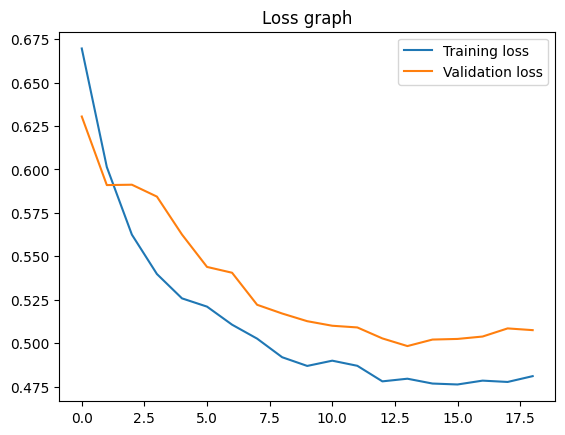

In [33]:
# Plot loss graph
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title("Loss graph")
plt.show()

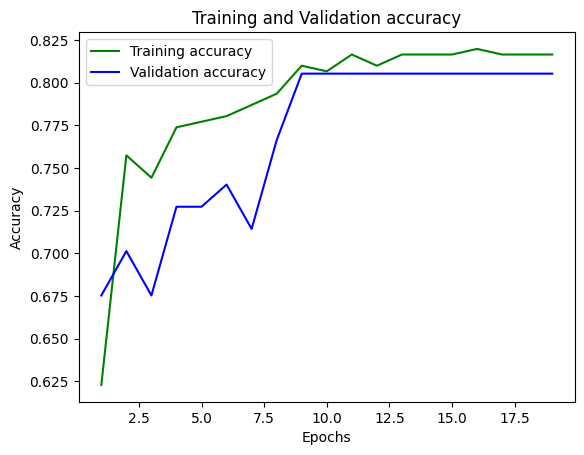

In [34]:
# plot accuracy graph
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1,len(accuracy_val) + 1)
plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model's metrics on 20 datasets

In [16]:
from sklearn.metrics import classification_report

In [17]:
shuffled_df = lagged_data.sample(frac=1, random_state=4)

In [18]:
num_datasets = 20
datasets = np.array_split(shuffled_df, num_datasets)

In [19]:
xscaler = MinMaxScaler(feature_range=(0, 1))

In [20]:
saved_model = tf.keras.models.load_model('bilstm_direction_7_day_lag_3_day_window')

In [21]:
saved_model.summary()

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_200 (Bidirect  (None, 3, 244)           124928    
 ional)                                                          
                                                                 
 dropout_200 (Dropout)       (None, 3, 244)            0         
                                                                 
 bidirectional_201 (Bidirect  (None, 244)              358192    
 ional)                                                          
                                                                 
 dropout_201 (Dropout)       (None, 244)               0         
                                                                 
 dense_100 (Dense)           (None, 2)                 490       
                                                                 
Total params: 483,610
Trainable params: 483,610
Non-

In [22]:
micro_precision_list = []
micro_recall_list = []
micro_f1_list = []

macro_precision_list = []
macro_recall_list = []
macro_f1_list = []

weighted_precision_list = []
weighted_recall_list = []
weighted_f1_list = []

samples_precision_list = []
samples_recall_list = []
samples_f1_list = []

In [23]:
for dataset in datasets:
    X = dataset.iloc[:, :total_features].values
    y = dataset['feature1(t)'].values
    X = xscaler.fit_transform(X)
    X = X.reshape((X.shape[0], n_lag, n_features))
    
    y_pred = saved_model.predict(X)
    y_true = keras.utils.to_categorical(y, 2)
    
    max_indices = np.argmax(y_pred, axis=1)
    one_hot_encoded = np.zeros_like(y_pred)
    one_hot_encoded[np.arange(len(y_pred)), max_indices] = 1
    
    report = classification_report(y_true, one_hot_encoded, output_dict=True, zero_division=0)
    
    micro_precision_list.append(report['micro avg']['precision'])
    micro_recall_list.append(report['micro avg']['recall'])
    micro_f1_list.append(report['micro avg']['f1-score'])
    
    macro_precision_list.append(report['macro avg']['precision'])
    macro_recall_list.append(report['macro avg']['recall'])
    macro_f1_list.append(report['macro avg']['f1-score'])
    
    weighted_precision_list.append(report['weighted avg']['precision'])
    weighted_recall_list.append(report['weighted avg']['recall'])
    weighted_f1_list.append(report['weighted avg']['f1-score'])
    
    samples_precision_list.append(report['samples avg']['precision'])
    samples_recall_list.append(report['samples avg']['recall'])
    samples_f1_list.append(report['samples avg']['f1-score'])

1/1 [==============================] - 0s 19ms/step


In [24]:
avg_micro_precision = np.mean(micro_precision_list)
avg_micro_recall = np.mean(micro_recall_list)
avg_micro_f1 = np.mean(micro_f1_list)

avg_macro_precision = np.mean(macro_precision_list)
avg_macro_recall = np.mean(macro_recall_list)
avg_macro_f1 = np.mean(macro_f1_list)

avg_weighted_precision = np.mean(weighted_precision_list)
avg_weighted_recall = np.mean(weighted_recall_list)
avg_weighted_f1 = np.mean(weighted_f1_list)

avg_samples_precision = np.mean(samples_precision_list)
avg_samples_recall = np.mean(samples_recall_list)
avg_samples_f1 = np.mean(samples_f1_list)

In [25]:
print('Micro')
print(f'Average Micro Precision: {avg_micro_precision}')
print(f'Average Micro Recall: {avg_micro_recall}')
print(f'Average Micro F1-score: {avg_micro_f1}')

print('\n\nMacro')
print(f'Average Macro Precision: {avg_macro_precision}')
print(f'Average Macro Recall: {avg_macro_recall}')
print(f'Average Macro F1-score: {avg_macro_f1}')

print('\n\nWeighted')
print(f'Average Weighted Precision: {avg_weighted_precision}')
print(f'Average Weighted Recall: {avg_weighted_recall}')
print(f'Average Weighted F1-score: {avg_weighted_f1}')

print('\n\nSamples')
print(f'Average Samples Precision: {avg_samples_precision}')
print(f'Average Samples Recall: {avg_samples_recall}')
print(f'Average Samples F1-score: {avg_samples_f1}')

Micro
Average Micro Precision: 0.8147233201581029
Average Micro Recall: 0.8147233201581029
Average Micro F1-score: 0.8147233201581029


Macro
Average Macro Precision: 0.8099495643245644
Average Macro Recall: 0.8180809121434122
Average Macro F1-score: 0.8087251039032839


Weighted
Average Weighted Precision: 0.8271718487924021
Average Weighted Recall: 0.8147233201581029
Average Weighted F1-score: 0.8160081939380819


Samples
Average Samples Precision: 0.8147233201581029
Average Samples Recall: 0.8147233201581029
Average Samples F1-score: 0.8147233201581029


In [26]:
model_file = 'direction model.png'
tf.keras.utils.plot_model(saved_model, to_file=model_file, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
data = {
    'micro_precision': micro_precision_list,
    'micro_recall': micro_recall_list,
    'micro_f1': micro_f1_list,
    'macro_precision': macro_precision_list,
    'macro_recall': macro_recall_list,
    'macro_f1': macro_f1_list,
    'weighted_precision': weighted_precision_list,
    'weighted_recall': weighted_recall_list,
    'weighted_f1': weighted_f1_list,
    'samples_precision': samples_precision_list,
    'samples_recall': samples_recall_list,
    'samples_f1': samples_f1_list,
}

In [28]:
metrics_df = pd.DataFrame(data)

In [29]:
metrics_df

,micro_precision,micro_recall,micro_f1,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1,samples_precision,samples_recall,samples_f1
0,0.869565,0.869565,0.869565,0.884615,0.884615,0.869565,0.899666,0.869565,0.869565,0.869565,0.869565,0.869565
1,0.869565,0.869565,0.869565,0.884615,0.884615,0.869565,0.899666,0.869565,0.869565,0.869565,0.869565,0.869565
2,0.739130,0.739130,0.739130,0.742424,0.746154,0.738636,0.752306,0.739130,0.740119,0.739130,0.739130,0.739130
3,0.782609,0.782609,0.782609,0.773077,0.781746,0.775828,0.788963,0.782609,0.784304,0.782609,0.782609,0.782609
4,0.913043,0.913043,0.913043,0.923077,0.916667,0.912879,0.926421,0.913043,0.912714,0.913043,0.913043,0.913043
5,0.956522,0.956522,0.956522,0.937500,0.968750,0.950538,0.961957,0.956522,0.957270,0.956522,0.956522,0.956522
6,0.826087,0.826087,0.826087,0.829545,0.834615,0.825758,0.839921,0.826087,0.826746,0.826087,0.826087,0.826087
7,0.869565,0.869565,0.869565,0.871212,0.871212,0.869565,0.872859,0.869565,0.869565,0.869565,0.869565,0.869565
8,0.869565,0.869565,0.869565,0.867424,0.873077,0.868571,0.873847,0.869565,0.870062,0.869565,0.869565,0.869565
9,0.826087,0.826087,0.826087,0.825758,0.825758,0.825758,0.826087,0.826087,0.826087,0.826087,0.826087,0.826087


In [30]:
# Get the minimum value of each column
min_values = metrics_df.min()

# Get the maximum value of each column
max_values = metrics_df.max()

print('Minimum Values:')
print(min_values)

print('\n\nMaximum Values:')
print(max_values)

Minimum Values:
micro_precision       0.681818
micro_recall          0.681818
micro_f1              0.681818
macro_precision       0.669643
macro_recall          0.662393
macro_f1              0.664488
weighted_precision    0.677760
weighted_recall       0.681818
weighted_f1           0.678352
samples_precision     0.681818
samples_recall        0.681818
samples_f1            0.681818
dtype: float64


Maximum Values:
micro_precision       0.956522
micro_recall          0.956522
micro_f1              0.956522
macro_precision       0.937500
macro_recall          0.968750
macro_f1              0.950538
weighted_precision    0.961957
weighted_recall       0.956522
weighted_f1           0.957270
samples_precision     0.956522
samples_recall        0.956522
samples_f1            0.956522
dtype: float64
